In [ ]:
import tensorflow as tf
import numpy as np
import os
import pickle
import copy
import skimage.io
import skimage.segmentation
from skimage import filters
import pandas as pd
import cv2
import random
import sys
import gc

from numpy import asarray
from tensorflow import keras
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing.image import load_img, img_to_array

In [ ]:
dataset_names = ["imagenette", "oxpets", "pvoc"]
model_names = ["inception_v3", "resnet50", "xception"]

#!mkdir drive/MyDrive/PhD/Results/sanity/FRIES/res_sal_metrics/imagenette/
#!mkdir drive/MyDrive/PhD/Results/sanity/FRIES/res_sal_metrics/pvoc/
#!mkdir drive/MyDrive/PhD/Results/sanity/FRIES/res_sal_metrics/imagenette/inception_v3/
#!mkdir drive/MyDrive/PhD/Results/sanity/FRIES/res_sal_metrics/imagenette/resnet50/
#!mkdir drive/MyDrive/PhD/Results/sanity/FRIES/res_sal_metrics/imagenette/xception/
#!mkdir drive/MyDrive/PhD/Results/sanity/FRIES/res_sal_metrics/pvoc/inception_v3/
#!mkdir drive/MyDrive/PhD/Results/sanity/FRIES/res_sal_metrics/pvoc/resnet50/
#!mkdir drive/MyDrive/PhD/Results/sanity/FRIES/res_sal_metrics/pvoc/xception/

!cp drive/MyDrive/PhD/Results/sanity/FRIES/datasets/* .
!unzip imagenette_500.zip
!unzip pvoc_500.zip
!find imagenette_500/ -type f -name "*.JPEG" -exec bash -c 'mv "$0" "${0%.JPEG}.jpg"' {} \;

In [ ]:
import os
import urllib.request
import tarfile

def download_and_extract(url, extract_dir):
    # Create the directory if it doesn't exist
    if not os.path.exists(extract_dir):
        os.makedirs(extract_dir)

    # Download the tar file
    tar_filename = os.path.join(extract_dir, "dataset.tar.gz")
    urllib.request.urlretrieve(url, tar_filename)

    # Extract the tar file
    with tarfile.open(tar_filename, 'r:gz') as tar:
        tar.extractall(path=extract_dir)

    # Remove the downloaded tar file
    os.remove(tar_filename)

# URL to download the dataset
url = "http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"

# Directory to extract the dataset
extract_dir = "./oxpets"

# Download and extract the dataset
download_and_extract(url, extract_dir)

print("Oxford-IIIT Pets dataset downloaded and extracted successfully.")
!rm -rf oxpets_500
!mkdir oxpets_500
!cp oxpets/images/* oxpets_500

Oxford-IIIT Pets dataset downloaded and extracted successfully.


In [ ]:
#make directory structure
src = "/content/drive/MyDrive/PhD/Results/sanity/FRIES/res_sal_metrics"
dst = "/content/drive/MyDrive/PhD/Results/sanity/FRIES/res_sal_metrics_patch"

# Walk through the source directory
for root, dirs, files in os.walk(src):
    for dir_name in dirs:
        # Construct the full directory path
        src_dir = os.path.join(root, dir_name)
        # Calculate the relative path
        relative_path = os.path.relpath(src_dir, src)
        # Construct the destination directory path
        dst_dir = os.path.join(dst, relative_path)
        # Create the destination directory
        os.makedirs(dst_dir, exist_ok=True)

In [ ]:
def auc(arr):
    """Returns normalized Area Under Curve of the array."""
    if arr.size > 1:
        adjusted_sum = (arr.sum() - arr[0] / 2 - arr[-1] / 2)
        result = adjusted_sum / (arr.shape[0] - 1)
    else:
        # If arr has only one element, result is that element
        result = arr[0] if arr.size == 1 else np.nan

    #return (arr.sum() - arr[0] / 2 - arr[-1] / 2) / (arr.shape[0] - 1)
    return result


def select_n_random_pixels(img_size=(224,224), n=50):
    width, height = img_size[0], img_size[1]
    #rows, columns, _ = img.shape

    pixel_indices = [(y, x) for y in range(height) for x in range(width)]  # Correct order: (row, column)
    selected_pixels = random.sample(pixel_indices, n)
    return selected_pixels

def divide_into_halves(n):
    half = n // 2
    return half, half + (n % 2)

def generate_perturbed_images_cumulative(img, coords, patch_size = 9, pert_type = "IT"):
    height, width,_ = img.shape

    pert_images = []
    pert_image = copy.deepcopy(img)
    random_pixel_value = [random.randint(int(np.min(img)), int(np.max(img))) for _ in range(3)]
    for coord in coords:
        h1, h2 = divide_into_halves(patch_size)
        mask = np.zeros((height, width), dtype=np.uint8)
        y_min = max(int(coord[1]-(h1)),0)
        y_max = min(int(coord[1]+(h2)),height-1)

        x_min = max(int(coord[0]-(h1)),0)
        x_max = min(int(coord[0]+(h2)),width-1)

        #damaged_image[coord]=0

        if pert_type=='IT':
            mask[x_min:x_max, y_min:y_max] = 255
            damaged_image = copy.deepcopy(img)
            damaged_image[x_min:x_max, y_min:y_max] = [0, 0, 0]
            damaged_image = damaged_image.astype(np.uint8)
            try:
                output = cv2.inpaint(damaged_image, mask, 5, cv2.INPAINT_TELEA)
            except Exception as e:
                print("Error during TELEA cv2.inpaint:", e)

        elif pert_type=='IN':
            mask[x_min:x_max, y_min:y_max] = 255
            damaged_image = copy.deepcopy(img)
            damaged_image[x_min:x_max, y_min:y_max] = [0, 0, 0]
            damaged_image = damaged_image.astype(np.uint8)
            try:
                output = cv2.inpaint(damaged_image, mask, 5, cv2.INPAINT_NS)
            except Exception as e:
                print("Error during NS cv2.inpaint:", e)

        elif pert_type=='U0':
            output = copy.deepcopy(img)
            output[x_min:x_max, y_min:y_max] = np.min(img) #[0, 0, 0]

        elif pert_type=='U.5':
            output = copy.deepcopy(img)
            output[x_min:x_max, y_min:y_max] = np.mean(img) #[127, 127, 127]

        elif pert_type=='U1':
            output = copy.deepcopy(img)
            output[x_min:x_max, y_min:y_max] = np.max(img) #[255, 255, 255]

        elif pert_type=='FR':
            output = copy.deepcopy(img)
            output[x_min:x_max, y_min:y_max] = random_pixel_value

        elif pert_type=='G3':
            output = filters.gaussian(img, 0.3, channel_axis=2, preserve_range=True)
            #tf.keras.preprocessing.image.save_img('pert_img_log/output.jpg', output)

        elif pert_type=='G9':
            output = filters.gaussian(img, 0.9, channel_axis=2, preserve_range=True)

        elif pert_type=='G15':
            output = filters.gaussian(img, 1.5, channel_axis=2, preserve_range=True)
        else:
            print("Unknown Type")
            return None


        #pert_image[x_min:x_max, y_min:y_max] = output[x_min:x_max, y_min:y_max]
        pert_image[coord[0], coord[1]] = output[coord[0], coord[1]]
        pert_images.append(copy.deepcopy(pert_image))

    return pert_images


def generate_perturbed_images_cumulative_patch(img, coords, patch_size=9, pert_type="IT"):
    height, width, _ = img.shape

    pert_images = []
    pert_image = copy.deepcopy(img)
    random_pixel_value = [random.randint(int(np.min(img)), int(np.max(img))) for _ in range(3)]
    for coord in coords:
        h1, h2 = divide_into_halves(patch_size)
        mask = np.zeros((height, width), dtype=np.uint8)
        y_min = max(int(coord[1] - h1), 0)
        y_max = min(int(coord[1] + h2), height)
        x_min = max(int(coord[0] - h1), 0)
        x_max = min(int(coord[0] + h2), width)

        if pert_type == 'IT':
            mask[y_min:y_max, x_min:x_max] = 255
            damaged_image = copy.deepcopy(img)
            damaged_image[y_min:y_max, x_min:x_max] = [0, 0, 0]
            damaged_image = damaged_image.astype(np.uint8)
            try:
                output = cv2.inpaint(damaged_image, mask, 5, cv2.INPAINT_TELEA)
            except Exception as e:
                print("Error during TELEA cv2.inpaint:", e)

        elif pert_type == 'IN':
            mask[y_min:y_max, x_min:x_max] = 255
            damaged_image = copy.deepcopy(img)
            damaged_image[y_min:y_max, x_min:x_max] = [0, 0, 0]
            damaged_image = damaged_image.astype(np.uint8)
            try:
                output = cv2.inpaint(damaged_image, mask, 5, cv2.INPAINT_NS)
            except Exception as e:
                print("Error during NS cv2.inpaint:", e)

        elif pert_type == 'U0':
            output = copy.deepcopy(img)
            output[y_min:y_max, x_min:x_max] = np.min(img)

        elif pert_type == 'U.5':
            output = copy.deepcopy(img)
            output[y_min:y_max, x_min:x_max] = np.mean(img)

        elif pert_type == 'U1':
            output = copy.deepcopy(img)
            output[y_min:y_max, x_min:x_max] = np.max(img)

        elif pert_type == 'FR':
            output = copy.deepcopy(img)
            output[y_min:y_max, x_min:x_max] = random_pixel_value

        elif pert_type == 'G3':
            output = filters.gaussian(img, 0.3, channel_axis=2, preserve_range=True)

        elif pert_type == 'G9':
            output = filters.gaussian(img, 0.9, channel_axis=2, preserve_range=True)

        elif pert_type == 'G15':
            output = filters.gaussian(img, 1.5, channel_axis=2, preserve_range=True)
        else:
            print("Unknown Type")
            return None

        pert_image[y_min:y_max, x_min:x_max] = output[y_min:y_max, x_min:x_max]
        pert_images.append(copy.deepcopy(pert_image))

    return pert_images

def divide_into_halves(patch_size):
    h1 = patch_size // 2
    h2 = patch_size - h1
    return h1, h2


def generate_perturbed_images(img, coords, patch_size = 9, pert_type = "IT"):
    height, width,_ = img.shape

    pert_images = []
    random_pixel_value = [random.randint(int(np.min(img)), int(np.max(img))) for _ in range(3)]
    for coord in coords:
        h1, h2 = divide_into_halves(patch_size)
        mask = np.zeros((height, width), dtype=np.uint8)
        y_min = max(int(coord[1]-(h1)),0)
        y_max = min(int(coord[1]+(h2)),height-1)

        x_min = max(int(coord[0]-(h1)),0)
        x_max = min(int(coord[0]+(h2)),width-1)

        #damaged_image[coord]=0

        if pert_type=='IT':
            mask[x_min:x_max, y_min:y_max] = 255
            damaged_image = copy.deepcopy(img)
            damaged_image[x_min:x_max, y_min:y_max] = [0, 0, 0]
            damaged_image = damaged_image.astype(np.uint8)
            try:
                output = cv2.inpaint(damaged_image, mask, 5, cv2.INPAINT_TELEA)
            except Exception as e:
                print("Error during TELEA cv2.inpaint:", e)

        elif pert_type=='IN':
            mask[x_min:x_max, y_min:y_max] = 255
            damaged_image = copy.deepcopy(img)
            damaged_image[x_min:x_max, y_min:y_max] = [0, 0, 0]
            damaged_image = damaged_image.astype(np.uint8)
            try:
                output = cv2.inpaint(damaged_image, mask, 5, cv2.INPAINT_NS)
            except Exception as e:
                print("Error during NS cv2.inpaint:", e)

        elif pert_type=='U0':
            output = copy.deepcopy(img)
            output[x_min:x_max, y_min:y_max] = np.min(img) #[0, 0, 0]

        elif pert_type=='U.5':
            output = copy.deepcopy(img)
            output[x_min:x_max, y_min:y_max] = np.mean(img) #[127, 127, 127]

        elif pert_type=='U1':
            output = copy.deepcopy(img)
            output[x_min:x_max, y_min:y_max] = np.max(img) #[255, 255, 255]

        elif pert_type=='FR':
            output = copy.deepcopy(img)
            output[x_min:x_max, y_min:y_max] = random_pixel_value

        elif pert_type=='G3':
            output = filters.gaussian(img, 0.3, channel_axis=2, preserve_range=True)
            #tf.keras.preprocessing.image.save_img('pert_img_log/output.jpg', output)

        elif pert_type=='G9':
            output = filters.gaussian(img, 0.9, channel_axis=2, preserve_range=True)

        elif pert_type=='G15':
            output = filters.gaussian(img, 1.5, channel_axis=2, preserve_range=True)
        else:
            print("Unknown Type")
            return None

        pert_image = copy.deepcopy(img)
        #pert_image[x_min:x_max, y_min:y_max] = output[x_min:x_max, y_min:y_max]
        pert_image[coord[0], coord[1]] = output[coord[0], coord[1]]
        pert_images.append(pert_image)

    return pert_images


def generate_perturbed_images_patch(img, coords, patch_size=9, pert_type="IT"):
    height, width, _ = img.shape

    pert_images = []
    random_pixel_value = [random.randint(int(np.min(img)), int(np.max(img))) for _ in range(3)]
    for coord in coords:
        h1, h2 = divide_into_halves(patch_size)
        mask = np.zeros((height, width), dtype=np.uint8)
        y_min = max(int(coord[1] - h1), 0)
        y_max = min(int(coord[1] + h2), height)
        x_min = max(int(coord[0] - h1), 0)
        x_max = min(int(coord[0] + h2), width)

        if pert_type == 'IT':
            mask[y_min:y_max, x_min:x_max] = 255
            damaged_image = copy.deepcopy(img)
            damaged_image[y_min:y_max, x_min:x_max] = [0, 0, 0]
            damaged_image = damaged_image.astype(np.uint8)
            try:
                output = cv2.inpaint(damaged_image, mask, 5, cv2.INPAINT_TELEA)
            except Exception as e:
                print("Error during TELEA cv2.inpaint:", e)

        elif pert_type == 'IN':
            mask[y_min:y_max, x_min:x_max] = 255
            damaged_image = copy.deepcopy(img)
            damaged_image[y_min:y_max, x_min:x_max] = [0, 0, 0]
            damaged_image = damaged_image.astype(np.uint8)
            try:
                output = cv2.inpaint(damaged_image, mask, 5, cv2.INPAINT_NS)
            except Exception as e:
                print("Error during NS cv2.inpaint:", e)

        elif pert_type == 'U0':
            output = copy.deepcopy(img)
            output[y_min:y_max, x_min:x_max] = np.min(img)

        elif pert_type == 'U.5':
            output = copy.deepcopy(img)
            output[y_min:y_max, x_min:x_max] = np.mean(img)

        elif pert_type == 'U1':
            output = copy.deepcopy(img)
            output[y_min:y_max, x_min:x_max] = np.max(img)

        elif pert_type == 'FR':
            output = copy.deepcopy(img)
            output[y_min:y_max, x_min:x_max] = random_pixel_value

        elif pert_type == 'G3':
            output = filters.gaussian(img, 0.3, channel_axis=2, preserve_range=True)

        elif pert_type == 'G9':
            output = filters.gaussian(img, 0.9, channel_axis=2, preserve_range=True)

        elif pert_type == 'G15':
            output = filters.gaussian(img, 1.5, channel_axis=2, preserve_range=True)
        else:
            print("Unknown Type")
            return None

        pert_image = copy.deepcopy(img)
        pert_image[y_min:y_max, x_min:x_max] = output[y_min:y_max, x_min:x_max]
        pert_images.append(pert_image)

    return pert_images


def get_model_params(model_name):
    if model_name == "resnet50":
        model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=True)
        img_size = (224, 224)
        preprocess_input = tf.keras.applications.resnet50.preprocess_input

    elif model_name == "inception_v3":
        model = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet')
        img_size = (299, 299)
        preprocess_input = tf.keras.applications.inception_v3.preprocess_input

    elif model_name == "xception":
        model = tf.keras.applications.xception.Xception(weights='imagenet')
        img_size = (299, 299)
        preprocess_input = tf.keras.applications.xception.preprocess_input

    else:
        print("Unknown Model:", model_name)
        return None, None, None

    return model, img_size, preprocess_input


def get_dataset_params(dataset_name, model_name):
  cam_dir = 'drive/MyDrive/PhD/Results/sanity/cams_same_size/'+dataset_name+'/'+model_name+'/'
  img_dir = dataset_name + '_500/'
  result_dir = 'drive/MyDrive/PhD/Results/sanity/FRIES/res_sal_metrics_patch/' + dataset_name + '/' + model_name + '/'

  return cam_dir, result_dir, img_dir


def save_images(images, image_name, pert_type, save_dir= "pert_img_log/"):
    for i in np.arange(0, len(images), step=1):
        tf.keras.preprocessing.image.save_img('pert_img_log/' + image_name+ "_" + pert_type
                                                    + '_' + str(i) + '_.jpg', images[i])


def get_aopc_scores(img_arr, cam_dict, model, preprocess_input,
                    pert_pxl_list, pert_types, method = 'morf'): #'lerf'
    cam_keys = cam_dict.keys()
    img_arr_b = tf.expand_dims(preprocess_input(img_arr), axis=0)
    pred0 = model.predict(img_arr_b)
    top_pred_class = pred0[0].argsort()[-1:][::-1]
    prob0 = pred0[0][top_pred_class]

    for pert_type in pert_types:

        aopc_scores=[]
        for cam_key in cam_keys:
            cam_map = cam_dict[cam_key]
            pert_pxl_array = np.array(pert_pxl_list)
            pert_values = cam_map[pert_pxl_array[:, 0], pert_pxl_array[:, 1]]
            sorted_indices = np.argsort(pert_values)[::-1]
            sorted_pert_pxl_list = pert_pxl_array[sorted_indices]


            diff_scores = []
            for i in np.arange(1, len(sorted_pert_pxl_list)+1,step=1):
                pert_img_arr = generate_perturbed_image(img = img_arr,
                                                        coords=sorted_pert_pxl_list[0:i],
                                                        patch_size=10, pert_type=pert_type,
                                                        is_cumulative=True)



                pert_img_arr = preprocess_input(pert_img_arr)
                pert_img_arr_b = tf.expand_dims(pert_img_arr, axis=0)
                pred = model.predict(pert_img_arr_b, verbose= False)
                prob = pred[0][top_pred_class]
                diff_scores.append(float(prob0-prob))
                del pert_img_arr, pert_img_arr_b
                gc.collect()
                #print(pert_type + " : " + str(float(prob0)) + " : ", str(float(prob)))






    return {'gradcam':10, 'gradcam++': 20}



def compute_ins(img_arr, pert_pixels_sorted, pert_type, model, top_pred_class): #both params should have same pixels and pixel order

    #not possible with inpainting
    return 1


def compute_del(img_arr, pert_pixels_sorted, pert_type, model, top_pred_class): #both params should have same pixels and pixel order

    pert_imgs = generate_perturbed_images_cumulative_patch(img_arr, pert_pixels_sorted, patch_size = 9,
                                                            pert_type = pert_type)
    pert_img_arrs = np.array(pert_imgs)
    pert_img_arrs = preprocess_input(pert_img_arrs)
    pred = model.predict(pert_img_arrs, verbose=False)
    probs = pred[:, top_pred_class]
    del_auc = 0
    # Calculate auc if probs is not empty
    if len(probs) != 0:
        del_auc = auc(np.array(probs))

    return del_auc


def compute_aopc(img_arr, pert_pixels_sorted, pert_type, model, top_pred_class, prob0): #both params should have same pixels and pixel order
    pert_imgs = generate_perturbed_images_cumulative_patch(img_arr, pert_pixels_sorted, patch_size = 9,
                                                            pert_type = pert_type)
    pert_img_arrs = np.array(pert_imgs)
    pert_img_arrs = preprocess_input(pert_img_arrs)
    pred = model.predict(pert_img_arrs, verbose=False)
    probs = pred[:, top_pred_class]
    probs_diff = prob0 - probs

    return np.mean(probs_diff)


def compute_faithfulness(prob_diff, cam_imp_values): # both should be for the same pixel order
    return np.corrcoef(cam_imp_values, prob_diff)[0, 1]

def get_faithfulness_scores(img_arr, cam_dict, model, preprocess_input,
                    pert_pxl_list, pert_types, image_name, method='morf'):  # 'lerf'
    cam_keys = cam_dict.keys()
    img_arr_b = tf.expand_dims(preprocess_input(copy.deepcopy(img_arr)), axis=0)
    pred0 = model.predict(img_arr_b, verbose=False)
    top_pred_class = pred0[0].argsort()[-1:][::-1]
    prob0 = pred0[0][top_pred_class]

    prob_diff_dict = {}
    arppd_dict = {}
    for pert_type in pert_types:
        pert_imgs = generate_perturbed_images_patch(img=img_arr,
                                              coords=pert_pxl_list,
                                              patch_size=9, pert_type=pert_type)
        pert_img_arrs = np.array(pert_imgs)
        pert_img_arrs = preprocess_input(pert_img_arrs)
        # pert_img_arr_b = tf.expand_dims(pert_img_arr, axis=0)
        pred = model.predict(pert_img_arrs, verbose=False)
        prob = pred[:, top_pred_class]
        prob_diff = prob0 - prob.flatten()
        prob_diff_dict[pert_type]=prob_diff
        arppd_dict[pert_type] = len(prob_diff[prob_diff>=0])/len(prob_diff)
        del pert_imgs, pert_img_arrs
        gc.collect()

    scores_dict = {}
    for pert_type in pert_types:
        scores = []
        for cam_key in cam_keys:
            cam_map = cam_dict[cam_key]
            if len(cam_map.shape) > 2:
                cam_map = cam_map[:, :, 0]
            pert_pxl_array = np.array(pert_pxl_list)
            cam_imp_values = cam_map[pert_pxl_array[:, 0], pert_pxl_array[:, 1]]
            prob_diff = prob_diff_dict[pert_type]
            cor_p = np.corrcoef(cam_imp_values, prob_diff)[0, 1]
            scores.append(cor_p)
            #print(pert_type + " : " + str(float(prob0)) + " : "+ cam_key + " : " + str(cor_p))

        scores_dict[pert_type]=dict(zip(cam_keys, scores))

    return scores_dict, prob_diff_dict, arppd_dict


def get_saliency_metric_scores(img_arr, cam_dict, model, preprocess_input,
                    pert_pxl_list, pert_types, image_name, method='morf'):  # 'lerf'
    cam_keys = cam_dict.keys()
    img_arr_b = tf.expand_dims(preprocess_input(copy.deepcopy(img_arr)), axis=0)
    pred0 = model.predict(img_arr_b, verbose=False)
    top_pred_class = pred0[0].argsort()[-1:][::-1]
    prob0 = pred0[0][top_pred_class]

    prob_diff_dict = {}
    arppd_dict = {}

    aopc_dict = {}
    del_dict = {}
    for pert_type in pert_types:
        del_scores = []
        ins_scores = []
        aopc_scores = []
        for cam_key in cam_keys:
            cam_map = cam_dict[cam_key]
            if len(cam_map.shape) > 2:
                cam_map = cam_map[:, :, 0]
            pert_pxl_array = np.array(pert_pxl_list)
            cam_imp_values = cam_map[pert_pxl_array[:, 0], pert_pxl_array[:, 1]]
            cam_rank_indices = np.argsort(cam_imp_values)[::-1]
            pert_pxl_array_sorted = pert_pxl_array[cam_rank_indices]
            del_score = compute_del(img_arr, pert_pxl_array_sorted, pert_type, model, top_pred_class)
            del_scores.append(del_score)
            aopc_score = compute_aopc(img_arr, pert_pxl_array_sorted, pert_type,model, top_pred_class, prob0)
            aopc_scores.append(aopc_score)

        del_dict[pert_type]=dict(zip(cam_keys, del_scores))
        aopc_dict[pert_type]= dict(zip(cam_keys, aopc_scores))

    return del_dict, aopc_dict


def get_pert_pixel_probs(img_arr, model, preprocess_input, pert_pxl_list, pert_types,
                         batch_size=50):
    img_arr_b = tf.expand_dims(preprocess_input(copy.deepcopy(img_arr)), axis=0)
    pred0 = model.predict(img_arr_b)
    top_pred_class = pred0[0].argsort()[-1:][::-1]
    prob0 = pred0[0][top_pred_class]

    pert_probs_diff_dict = {}
    for pert_type in pert_types:
        probs_diff_arr = []
        for batch_num in range(0, len(pert_pxl_list), batch_size):
            batch_pxl_list = pert_pxl_list[batch_num:(batch_num + batch_size)]
            pert_imgs = generate_perturbed_images(copy.deepcopy(img_arr), batch_pxl_list, pert_type=pert_type)
            preds = model.predict(np.array(pert_imgs), verbose=False)
            probs_arr_batch = preds[:, top_pred_class]
            diff_batch = prob0 - probs_arr_batch.flatten()
            probs_diff_arr.extend(diff_batch)
            del pert_imgs
            gc.collect()
        pert_probs_diff_dict[pert_type]=probs_diff_arr

    return pert_probs_diff_dict

def get_pert_pixel_probs_cummulative(img_arr, model, preprocess_input, pert_pxl_list, pert_types, batch_size=50):
    img_arr_b = tf.expand_dims(preprocess_input(copy.deepcopy(img_arr)), axis=0)
    pred0 = model.predict(img_arr_b)
    top_pred_class = pred0[0].argsort()[-1:][::-1]
    prob0 = pred0[0][top_pred_class]

    pert_probs_diff_dict = {}
    for pert_type in pert_types:
        probs_diff_arr = []
        for batch_num in range(0, len(pert_pxl_list), batch_size):
            batch_pxl_list = pert_pxl_list[batch_num:(batch_num + batch_size)]
            pert_imgs = generate_perturbed_images_cumulative_patch(copy.deepcopy(img_arr), batch_pxl_list, pert_type=pert_type)
            pert_img_arrs = np.array(pert_imgs)
            #print(f"Perturbed images shape (before preprocess): {pert_img_arrs.shape}")
            pert_img_arrs = preprocess_input(pert_img_arrs)
            #print(f"Perturbed images shape (after preprocess): {pert_img_arrs.shape}")
            preds = model.predict(pert_img_arrs, verbose=False)
            #print(f"Predictions shape: {preds.shape}, Predictions: {preds}")
            probs_arr_batch = preds[:, top_pred_class]
            #print(f"Probabilities batch: {probs_arr_batch}")
            if np.all(probs_arr_batch == 0):
                print("Warning: All probabilities are zero in this batch.")
            diff_batch = prob0 - probs_arr_batch.flatten()
            probs_diff_arr.extend(diff_batch)
            del pert_imgs
            gc.collect()
        pert_probs_diff_dict[pert_type] = probs_diff_arr

    return pert_probs_diff_dict

In [ ]:
num_pxls = 50
batch_size = 5
pert_types = ["IT", "IN", "U0", "U1", "U.5", "FR", "G3", "G9", "G15"]
model_names = ["xception", "resnet50", "inception_v3"]
datasets = ["oxpets", "imagenette", "pvoc"]
log_id = 1

with tf.device('/device:GPU:0'):
    for dataset in datasets:
        for model_name in model_names:
            cam_dir, results_dir, img_dir = get_dataset_params(dataset, model_name)
            model, img_size, preprocess_input = get_model_params(model_name)
            probs_list = []
            cam_paths = os.listdir(cam_dir)
            for cam_path in cam_paths:
                with open(cam_dir + cam_path, 'rb') as file:
                    # Load the object from the pickle file
                    cam_dict = pickle.load(file)
                    #print(cam_dict.keys())

                img_path = cam_path.replace('_cams.pkl', '.jpg')
                pkl_filename = results_dir + img_path.replace('.jpg', '_') + "scores.pkl"
                print(pkl_filename)

                if os.path.exists(pkl_filename):
                    print("Already Done: " + str(pkl_filename))
                    continue

                if not os.path.exists(img_dir + img_path):
                    continue

                img = load_img(img_dir + img_path, target_size=img_size, color_mode='rgb')
                img_arr = img_to_array(img)

                pert_pxl_list = select_n_random_pixels(img_size, num_pxls)

                cummulative_probs_dict = get_pert_pixel_probs_cummulative(img_arr, model, preprocess_input, pert_pxl_list, pert_types)

                faithfulness_scores_dict, prob_diff_dict, arppd_dict = get_faithfulness_scores(
                    img_arr, cam_dict, model, preprocess_input, pert_pxl_list, pert_types, image_name=img_path)

                del_dict, aopc_dict = get_saliency_metric_scores(
                    img_arr, cam_dict, model, preprocess_input, pert_pxl_list, pert_types, image_name=img_path)

                with open(pkl_filename, 'wb') as f1:
                    pickle.dump([faithfulness_scores_dict, del_dict, aopc_dict, prob_diff_dict, arppd_dict, pert_pxl_list, cummulative_probs_dict], f1)

                print("log_id", log_id)
                log_id += 1

print(os.getcwd())

In [ ]:
### RPD Plots
import os
import pickle
import tensorflow as tf
#from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from PIL import Image

num_pxls = 50
batch_size = 5
pert_types = ['U0'] #["IT", "IN", "U0", "U1", "U.5", "FR", "G3", "G9", "G15"]
model_names = ["xception"] #["xception", "resnet50", "inception_v3"]
datasets = ["oxpets"] #["oxpets", "imagenette", "pvoc"]
log_id = 1

# Directory where perturbed images will be saved
output_dir = "pert_images"
os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists

def save_image(image_array, output_path):
    """Save the image from a numpy array."""
    img = Image.fromarray(np.uint8(image_array))  # Convert array to an image
    img.save(output_path)

with tf.device('/device:GPU:0'):
    for dataset in datasets:
        for model_name in model_names:
            cam_dir, results_dir, img_dir = get_dataset_params(dataset, model_name)
            model, img_size, preprocess_input = get_model_params(model_name)
            probs_list = []
            cam_paths = os.listdir(cam_dir)

            cam_paths = cam_paths[9:10]
            for idx, cam_path in enumerate(cam_paths):
                with open(os.path.join(cam_dir, cam_path), 'rb') as file:
                    cam_dict = pickle.load(file)

                img_path = os.path.join(img_dir, cam_path.replace('_cams.pkl', '.jpg'))  # Assuming images are in JPG format
                img = load_img(img_path, target_size=img_size, color_mode='rgb')
                img_arr = img_to_array(img)

                img_arr_b = tf.expand_dims(preprocess_input(copy.deepcopy(img_arr)), axis=0)
                pred0 = model.predict(img_arr_b)
                top_pred_class = pred0[0].argsort()[-1:][::-1]
                prob0 = pred0[0][top_pred_class]
                print(f"Top pred Class: {top_pred_class} and Prob0={prob0}")


                pert_pxl_list = select_n_random_pixels(img_size, num_pxls)

                # Loop through each perturbation type
                for pert_type in pert_types:
                    perturbed_images = generate_perturbed_images_patch(img=img_arr, coords=pert_pxl_list, patch_size=9, pert_type=pert_type)
                    pert_img_arrs = np.array(perturbed_images)
                    pert_img_arrs = preprocess_input(pert_img_arrs)
                    preds = model.predict(pert_img_arrs, verbose=False)
                    probs_arr_batch = preds[:, top_pred_class]

                    # Save each perturbed image
                    for pert_idx, pert_image in enumerate(perturbed_images):
                        output_filename = f"{dataset}_{model_name}_{pert_type}_{cam_path[:-4]}_{pert_idx}.png"  # Create filename
                        output_path = os.path.join(output_dir, output_filename)
                        save_image(pert_image, output_path)  # Save perturbed image

print(f"Images saved in {os.getcwd()}/{output_dir}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Top pred Class: [168] and Prob0=[0.32999974]


Images saved in /content/pert_images


In [ ]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

with open('imagenet_classes.txt') as f:
    imagenet_labels = [line.strip() for line in f.readlines()]

--2024-10-20 14:40:33--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt.1’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2024-10-20 14:40:33 (133 MB/s) - ‘imagenet_classes.txt.1’ saved [10472/10472]



In [ ]:
# RPD plotting code
import os
import pickle
import tensorflow as tf
import numpy as np
import copy
import csv
from PIL import Image

num_pxls = 50
batch_size = 5
pert_types = ['U1']  # ["IT", "IN", "U0", "U1", "U.5", "FR", "G3", "G9", "G15"]
model_names = ["xception"]  # ["xception", "resnet50", "inception_v3"]
datasets = ["oxpets"]  # ["oxpets", "imagenette", "pvoc"]
log_id = 1

num_saved_images = 6
# Directory where perturbed images will be saved
output_dir = "pert_images"
os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists

# CSV file path for saving image filenames and output probabilities
csv_file = os.path.join(output_dir, "perturbed_image_probabilities.csv")

# Function to save image
def save_image(image_array, output_path):
    """Save the image from a numpy array."""
    img = Image.fromarray(np.uint8(image_array))  # Convert array to an image
    img.save(output_path)

# Open CSV file for writing
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["filename", "probability", "compared_to_prob0"])  # Header

    with tf.device('/device:GPU:0'):
        for dataset in datasets:
            for model_name in model_names:
                cam_dir, results_dir, img_dir = get_dataset_params(dataset, model_name)
                model, img_size, preprocess_input = get_model_params(model_name)
                cam_paths = os.listdir(cam_dir)

                cam_paths = cam_paths[9:10]  # 27:28 #9:10
                for idx, cam_path in enumerate(cam_paths):
                    with open(os.path.join(cam_dir, cam_path), 'rb') as file:
                        cam_dict = pickle.load(file)

                    img_path = os.path.join(img_dir, cam_path.replace('_cams.pkl', '.jpg'))  # Assuming images are in JPG format
                    img = load_img(img_path, target_size=img_size, color_mode='rgb')
                    img_arr = img_to_array(img)

                    # Preprocess and predict on the original image
                    img_arr_b = tf.expand_dims(preprocess_input(copy.deepcopy(img_arr)), axis=0)
                    pred0 = model.predict(img_arr_b)
                    top_pred_class = pred0[0].argsort()[-1:][::-1]
                    prob0 = pred0[0][top_pred_class][0]  # Extract the scalar probability value
                    print(f"Top pred Class: {top_pred_class[0]} ({imagenet_labels[top_pred_class[0]]}) and Prob0={prob0}")


                    # Save the original image and log it in the CSV file
                    original_filename = f"{dataset}_{model_name}_original_{cam_path[:-4]}.png"
                    original_path = os.path.join(output_dir, original_filename)
                    save_image(img_arr, original_path)
                    writer.writerow([original_filename, prob0, "original"])  # Log original image and its probability

                    # Generate perturbed images
                    pert_pxl_list = select_n_random_pixels(img_size, num_pxls)

                    # Initialize lists to store qualifying images
                    images_greater_than_prob0 = []
                    images_less_than_prob0 = []

                    # Loop through each perturbation type
                    for pert_type in pert_types:
                        perturbed_images = generate_perturbed_images_patch(img=img_arr, coords=pert_pxl_list, patch_size=9, pert_type=pert_type)
                        pert_img_arrs = np.array(perturbed_images)
                        pert_img_arrs = preprocess_input(pert_img_arrs)
                        preds = model.predict(pert_img_arrs, verbose=False)
                        probs_arr_batch = preds[:, top_pred_class]

                        # Classify the perturbed images based on probability comparison with prob0
                        for pert_idx, pert_image in enumerate(perturbed_images):
                            output_filename = f"{dataset}_{model_name}_{pert_type}_{cam_path[:-4]}_{pert_idx}.png"  # Create filename
                            output_path = os.path.join(output_dir, output_filename)
                            prob_pert = probs_arr_batch[pert_idx][0]  # Get the scalar probability

                            # Compare probability with prob0
                            if prob_pert > prob0 and len(images_greater_than_prob0) < num_saved_images/2:
                                images_greater_than_prob0.append((pert_image, output_filename, prob_pert))
                            elif prob_pert < prob0 and len(images_less_than_prob0) < num_saved_images/2:
                                images_less_than_prob0.append((pert_image, output_filename, prob_pert))

                            # Stop collecting once we have 4 images for each category
                            if len(images_greater_than_prob0) == (num_saved_images/2) and len(images_less_than_prob0) == num_saved_images/2:
                                break

                        # If we have enough images, we can stop early
                        if len(images_greater_than_prob0) == (num_saved_images/2) and len(images_less_than_prob0) == num_saved_images/2:
                            break

                    # Save selected perturbed images and log them to CSV
                    for pert_image, output_filename, prob_pert in images_greater_than_prob0 + images_less_than_prob0:
                        compared_to_prob0 = "greater" if prob_pert > prob0 else "less"
                        writer.writerow([output_filename, prob_pert, compared_to_prob0])
                        # Save the image
                        save_image(pert_image, os.path.join(output_dir, output_filename))

print(f"Images saved in {os.getcwd()}/{output_dir}")
print(f"CSV file saved at {csv_file}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Top pred Class: 168 (redbone) and Prob0=0.32999974489212036
Images saved in /content/pert_images
CSV file saved at pert_images/perturbed_image_probabilities.csv


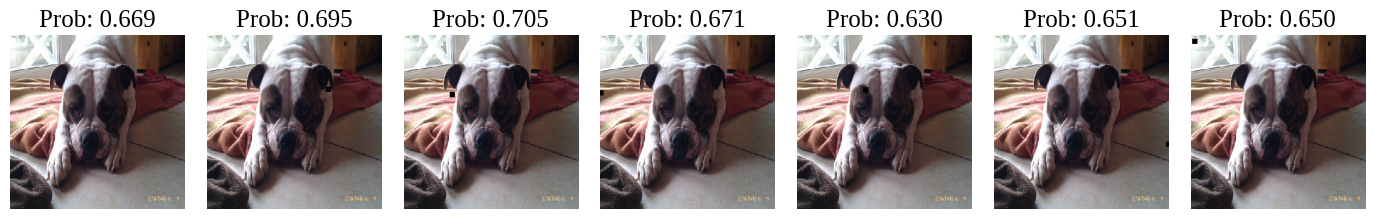

In [ ]:
import os
import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import matplotlib as mpl

# Configure font properties
mpl.rcParams['font.family'] = 'Liberation Serif'
mpl.rcParams['font.size'] = 15
mpl.rcParams['font.weight'] = 'bold'

# Directory where perturbed images are saved
output_dir = "pert_images"

# Path to the CSV file containing the filenames and probabilities
csv_file = os.path.join(output_dir, "perturbed_image_probabilities.csv")

# Load filenames and their corresponding probabilities from CSV
images_info = []
with open(csv_file, mode='r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        images_info.append((row['filename'], float(row['probability'])))

# Assuming the first entry corresponds to the original image
original_image_path = os.path.join(output_dir, images_info[0][0])
original_image = mpimg.imread(original_image_path)
original_prob = images_info[0][1]

# Load perturbed images and their probabilities (first image is the original)
perturbed_images = []
perturbed_probs = []

# Collect the first 6 perturbed images and their probabilities
for filename, prob in images_info[1:7]:  # Get only the first 6 perturbed images
    perturbed_images.append(mpimg.imread(os.path.join(output_dir, filename)))
    perturbed_probs.append(prob)

# Set up a horizontal plot with 7 images (1 original + 6 perturbed)
fig, axs = plt.subplots(1, 7, figsize=(14, 3))  # 7 columns, 1 row, width and height adjusted

# Display original image
axs[0].imshow(original_image)
axs[0].axis('off')
axs[0].set_title(f"Prob: {original_prob:.3f}")

# Display each perturbed image
for i in range(6):
    axs[i+1].imshow(perturbed_images[i])
    axs[i+1].axis('off')
    axs[i+1].set_title(f"Prob: {perturbed_probs[i]:.3f}")

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig('2_xception_U0.png')
plt.show()

In [ ]:
from PIL import Image

# Load the two large images (top row and bottom row images)
top_image = Image.open("1_xception_U0.png")  # Replace with the path to your top row image
bottom_image = Image.open("2_xception_U1.png")  # Replace with the path to your bottom row image

# Optionally crop the images if there is any unnecessary space around the edges
def crop_image(image):
    bbox = image.getbbox()  # Get bounding box of non-zero areas (non-transparent areas)
    if bbox:
        return image.crop(bbox)
    return image

# Crop both images to ensure no unwanted padding
top_image = crop_image(top_image)
bottom_image = crop_image(bottom_image)

# Ensure both images have the same width
if top_image.width != bottom_image.width:
    new_width = max(top_image.width, bottom_image.width)
    top_image = top_image.resize((new_width, int(top_image.height * new_width / top_image.width)))
    bottom_image = bottom_image.resize((new_width, int(bottom_image.height * new_width / bottom_image.width)))

# Create a new image by stacking them vertically
new_image_height = top_image.height + bottom_image.height
combined_image = Image.new('RGB', (top_image.width, new_image_height))

# Paste the two images, one on top of the other
combined_image.paste(top_image, (0, 0))
combined_image.paste(bottom_image, (0, top_image.height))

# Save the new image
combined_image.save("combined_image_no_space.jpg")
combined_image.show()  # Optional: display the new image

In [ ]:
import os
import pickle
import tensorflow as tf
import numpy as np
import copy
import csv
from PIL import Image

num_pxls = 50
batch_size = 5
pert_types = ['U0', 'U1']  # Working with U0 and U1
model_names = ["xception"]
datasets = ["oxpets"]

# Directory where perturbed images will be saved
output_dir = "pert_images/"
os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists

# CSV file path for saving image filenames and output probabilities
csv_file = os.path.join(output_dir, "perturbed_image_probabilities.csv")

# Function to save image
def save_image(image_array, output_path):
    img = Image.fromarray(np.uint8(image_array))  # Convert array to an image
    img.save(output_path)

# Open CSV file for writing
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Add columns for U0 and U1 probabilities, drops, and ranks
    writer.writerow(["filename", "probability_U0", "prob_drop_U0", "rank_U0", "probability_U1", "prob_drop_U1", "rank_U1"])

    with tf.device('/device:GPU:0'):
        for dataset in datasets:
            for model_name in model_names:
                cam_dir, results_dir, img_dir = get_dataset_params(dataset, model_name)
                model, img_size, preprocess_input = get_model_params(model_name)
                cam_paths = os.listdir(cam_dir)

                cam_paths = cam_paths[9:10]  # Use a subset of images for testing
                image_data = []

                for idx, cam_path in enumerate(cam_paths):
                    with open(os.path.join(cam_dir, cam_path), 'rb') as file:
                        cam_dict = pickle.load(file)

                    img_path = os.path.join(img_dir, cam_path.replace('_cams.pkl', '.jpg'))  # Assuming images are in JPG format
                    img = load_img(img_path, target_size=img_size, color_mode='rgb')
                    img_arr = img_to_array(img)

                    # Preprocess and predict on the original image
                    img_arr_b = tf.expand_dims(preprocess_input(copy.deepcopy(img_arr)), axis=0)
                    pred0 = model.predict(img_arr_b)
                    top_pred_class = pred0[0].argsort()[-1:][::-1]
                    prob0 = pred0[0][top_pred_class][0]  # Extract the scalar probability value

                    # Process both perturbation types (U0 and U1) for each image
                    prob_drops = {"U0": None, "U1": None}
                    pxl_coords = select_n_random_pixels(img_size, num_pxls)
                    for pert_type in pert_types:
                        perturbed_images = generate_perturbed_images_patch(img=img_arr, coords=pxl_coords, patch_size=9, pert_type=pert_type)
                        pert_img_arrs = np.array(perturbed_images)
                        pert_img_arrs = preprocess_input(pert_img_arrs)
                        preds = model.predict(pert_img_arrs, verbose=False)

                        for pert_idx, pert_image in enumerate(perturbed_images):
                            prob_pert = preds[pert_idx, top_pred_class][0]  # Get the scalar probability

                            # Calculate the probability drop
                            prob_drop = prob0 - prob_pert
                            prob_drops[pert_type] = (prob_pert, prob_drop)

                            # Save the perturbed image
                            output_filename = f"{dataset}_{model_name}_{pert_type}_{cam_path[:-4]}_{pert_idx}.png"
                            save_image(pert_image, os.path.join(output_dir, output_filename))

                            # Append to image data to track probabilities and ranks
                            image_data.append({
                                "filename": output_filename,
                                "pert_type": pert_type,
                                "prob_pert": prob_pert,
                                "prob_drop": prob_drop
                            })

                        del perturbed_images

                # Separate and sort by probability drop for U0 and U1
                u0_data = sorted([img for img in image_data if img["pert_type"] == 'U0'], key=lambda x: x['prob_drop'], reverse=True)
                u1_data = sorted([img for img in image_data if img["pert_type"] == 'U1'], key=lambda x: x['prob_drop'], reverse=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
# Open CSV file for writing
for rank, u0 in enumerate(u0_data):
    u0['rank_U0'] = rank + 1  # Rank starts from 1

for rank, u1 in enumerate(u1_data):
    u1['rank_U1'] = rank + 1  # Rank starts from

with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Add columns for U0 and U1 probabilities, drops, and ranks
    writer.writerow(["filename", "probability_U0", "prob_drop_U0", "rank_U0", "probability_U1", "prob_drop_U1", "rank_U1"])

    # Iterate through U0 data and match with U1 data based on filename
    for u0 in u0_data:
        # Extract the image ID from the filename for matching
        image_id = u0['filename'].replace('U0', '')

        # Find the corresponding U1 data for the same image
        matching_u1 = next((item for item in u1_data if item['filename'].replace('U1', '') == image_id), None)

        if matching_u1:
            # If matching U1 data is found, write both U0 and U1 data in the same row
            writer.writerow([
                u0['filename'],  # U0 filename
                u0['prob_pert'], u0['prob_drop'], u0['rank_U0'],  # U0 details
                matching_u1['prob_pert'], matching_u1['prob_drop'], matching_u1['rank_U1']  # U1 details
            ])
        else:
            # If no matching U1 data, write U0 data only (leave U1 fields as N/A)
            writer.writerow([
                u0['filename'],  # U0 filename
                u0['prob_pert'], u0['prob_drop'], u0['rank_U0'],
                'N/A', 'N/A', 'N/A'  # No U1 data
            ])

print(f"CSV file saved at {csv_file}")

CSV file saved at pert_images/perturbed_image_probabilities.csv


Combined image saved as combined_top7_images.png


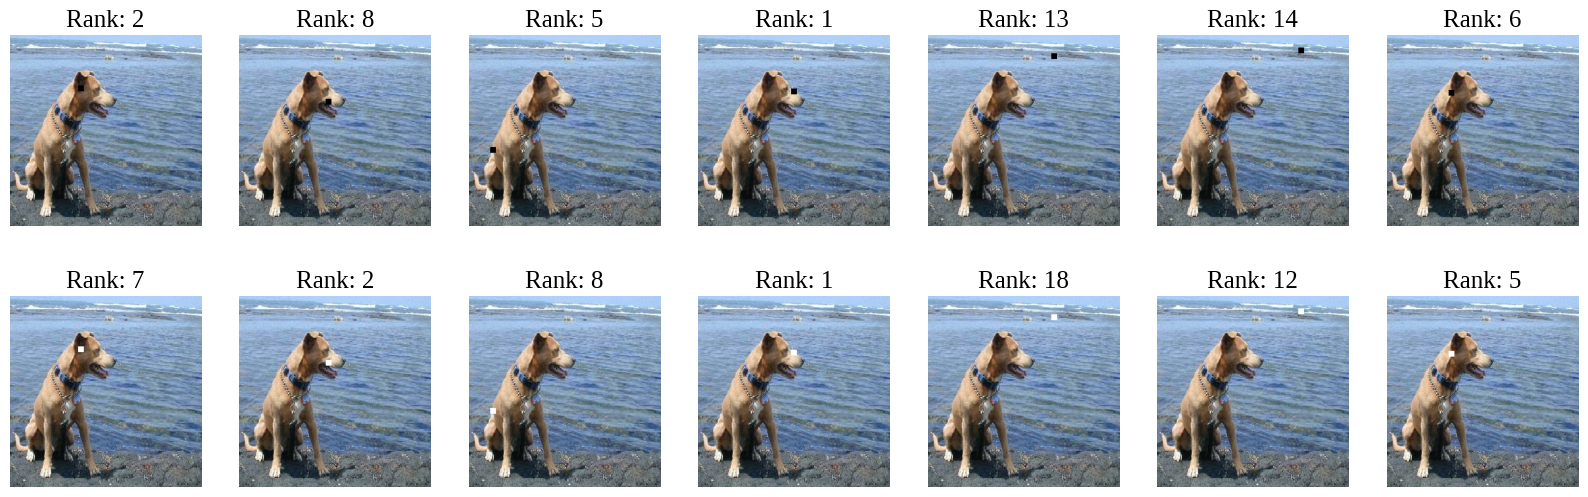

In [ ]:
import csv
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl

# Configure font properties
mpl.rcParams['font.family'] = 'Liberation Serif'
mpl.rcParams['font.size'] = 15
mpl.rcParams['font.weight'] = 'bold'

# Path to the CSV file and perturbed images
csv_file = 'pert_images/perturbed_image_probabilities.csv'
output_dir = 'pert_images/'
output_combined_image = 'combined_top7_images.png'

# Function to open and load images
def load_image(filename):
    return mpimg.imread(os.path.join(output_dir, filename))

# Read the CSV and filter rows where prob_drop_U0 or prob_drop_U1 is negative
images_info = []
with open(csv_file, mode='r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        prob_drop_U0 = float(row['prob_drop_U0'])
        prob_drop_U1 = float(row['prob_drop_U1'])

        # Filter out rows where prob_drop_U0 or prob_drop_U1 is negative
        if prob_drop_U0 >= 0 and prob_drop_U1 >= 0:
            images_info.append({
                "filename_U0": row['filename'],
                "filename_U1": row['filename'].replace('U0', 'U1'),
                "prob_U0": float(row['probability_U0']),
                "prob_U1": float(row['probability_U1']),
                "rank_U0": int(row['rank_U0']),
                "rank_U1": int(row['rank_U1']),
                "prob_drop_U0": prob_drop_U0,
                "prob_drop_U1": prob_drop_U1,
            })

# Sort the images based on rank change (descending)
images_info_sorted = sorted(images_info, key=lambda x: abs(x['prob_drop_U0'] - x['prob_drop_U1']), reverse=True)

# Select top 7 images with the highest rank change
top_7_images = images_info_sorted[:7]

# Create a matplotlib figure
fig, axs = plt.subplots(2, 7, figsize=(16, 6))  # Adjust the figure size

# Reduce the space on the left and right
plt.subplots_adjust(left=0.01, right=0.99, wspace=0.2, hspace=0.3)

# Plot U0 images on the top row and U1 images on the bottom row
for i, img_info in enumerate(top_7_images):
    # Load U0 and U1 images
    image_u0 = load_image(img_info['filename_U0'])
    image_u1 = load_image(img_info['filename_U1'])

    # Plot U0 image on the top row
    axs[0, i].imshow(image_u0)
    axs[0, i].axis('off')
    axs[0, i].set_title(f"Rank: {img_info['rank_U0']}")

    # Plot U1 image on the bottom row
    axs[1, i].imshow(image_u1)
    axs[1, i].axis('off')
    axs[1, i].set_title(f"Rank: {img_info['rank_U1']}")

# Save the final combined image
plt.savefig(output_combined_image, bbox_inches='tight')
print(f"Combined image saved as {output_combined_image}")
plt.savefig('prc_visualization.png')

# Show the image
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Probabilities: [0.32999974, 0.29587713, 0.32333782, 0.32998422, 0.36205944, 0.36418614, 0.3380746, 0.3609833, 0.35634586, 0.34102893, 0.30552825, 0.33364996, 0.34839386, 0.34142768, 0.35267824]
Probability Differences: [0.034122616, 0.0066619217, 1.552701e-05, -0.0320597, -0.034186393, -0.00807485, -0.030983567, -0.026346117, -0.011029184, 0.024471492, -0.0036502182, -0.018394113, -0.011427939, -0.022678494]


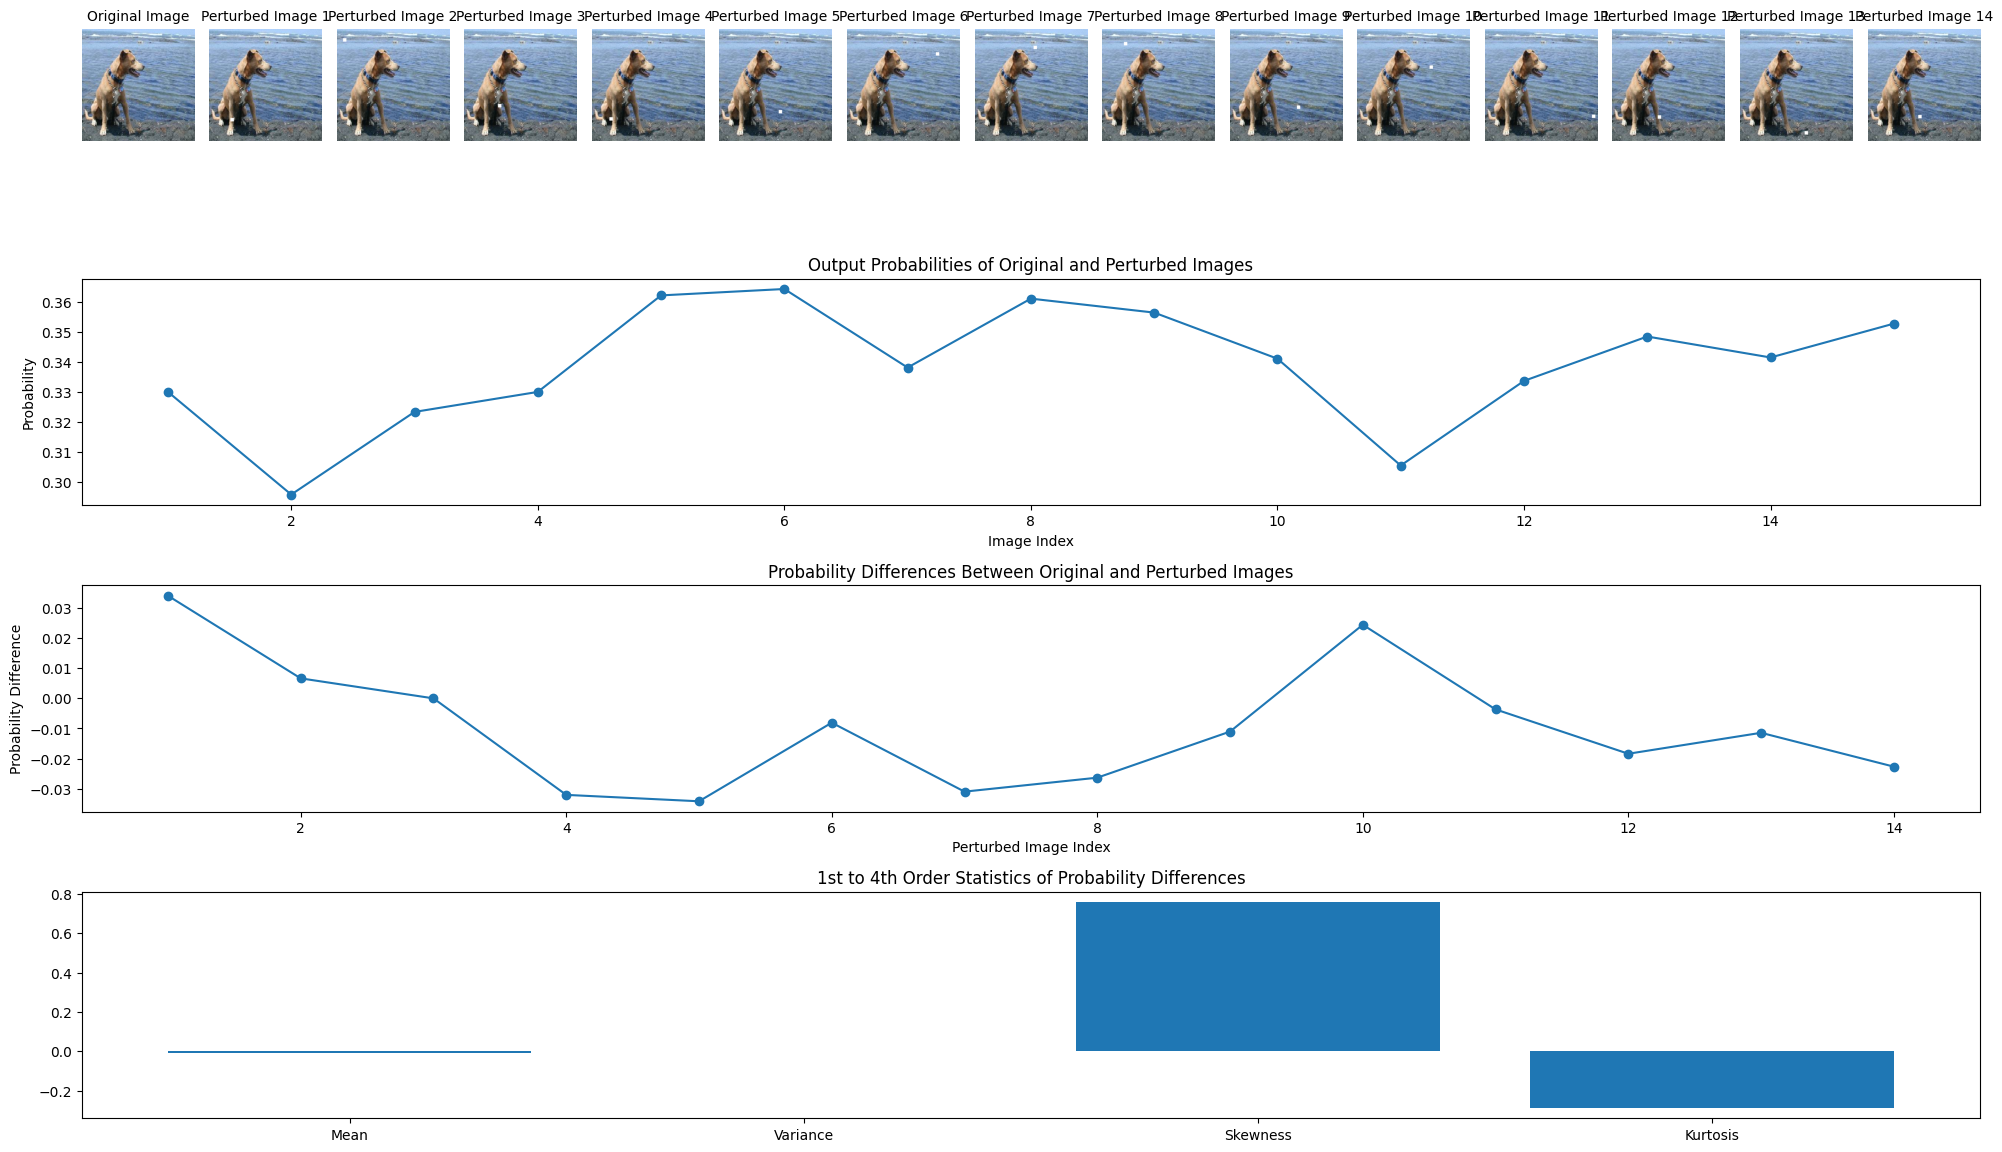

Images saved in /content/pert_images
CSV file saved at pert_images/perturbed_image_probabilities.csv


In [ ]:
import os
import pickle
import tensorflow as tf
import numpy as np
import copy
import csv
from PIL import Image
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# Your existing configurations
num_pxls = 50
batch_size = 5
pert_types = ['U1']
model_names = ["xception"]
datasets = ["oxpets"]
log_id = 1
num_saved_images = 14  # Updated to 14 perturbed images (total 15 with original)
output_dir = "pert_images"
os.makedirs(output_dir, exist_ok=True)
csv_file = os.path.join(output_dir, "perturbed_image_probabilities.csv")

# Function to save image (unchanged)
def save_image(image_array, output_path):
    img = Image.fromarray(np.uint8(image_array))
    img.save(output_path)

# Function to plot images, probabilities, probability differences, and 1st to 4th order statistics
def plot_images_and_statistics(original_image, perturbed_images, probabilities, prob_diffs):
    fig = plt.figure(figsize=(20, 12))

    # 1. Plot the images in 15 subplots (1 original + 14 perturbed)
    for i in range(15):
        ax = fig.add_subplot(4, 15, i + 1)  # Create a 4-row grid with 15 columns
        if i == 0:
            ax.imshow(original_image.astype('uint8'))
            ax.set_title(f"Original Image", fontsize=10)
        else:
            ax.imshow(perturbed_images[i-1].astype('uint8'))
            ax.set_title(f"Perturbed Image {i}", fontsize=10)
        ax.axis('off')

    # 2. Plot the actual probabilities in a line plot just below the images
    print("Probabilities:", probabilities)  # Diagnostic print
    ax = fig.add_subplot(4, 1, 2)
    ax.plot(range(1, len(probabilities) + 1), probabilities, marker='o')
    ax.set_title("Output Probabilities of Original and Perturbed Images")
    ax.set_xlabel("Image Index")
    ax.set_ylabel("Probability")

    # 3. Plot the probability differences in a line plot below the probability plot
    print("Probability Differences:", prob_diffs)  # Diagnostic print
    ax = fig.add_subplot(4, 1, 3)
    ax.plot(range(1, len(prob_diffs) + 1), prob_diffs, marker='o')
    ax.set_title("Probability Differences Between Original and Perturbed Images")
    ax.set_xlabel("Perturbed Image Index")
    ax.set_ylabel("Probability Difference")

    # 4. Compute and plot 1st to 4th order statistics in a bar plot
    mean_diff = np.mean(prob_diffs)
    var_diff = np.var(prob_diffs)
    skew_diff = skew(prob_diffs)
    kurt_diff = kurtosis(prob_diffs)

    statistics = [mean_diff, var_diff, skew_diff, kurt_diff]
    labels = ['Mean', 'Variance', 'Skewness', 'Kurtosis']

    ax = fig.add_subplot(4, 1, 4)
    ax.bar(labels, statistics)
    ax.set_title("1st to 4th Order Statistics of Probability Differences")

    plt.tight_layout()
    plt.show()

# Open CSV file for writing
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["filename", "probability", "compared_to_prob0"])  # Header

    with tf.device('/device:GPU:0'):
        for dataset in datasets:
            for model_name in model_names:
                cam_dir, results_dir, img_dir = get_dataset_params(dataset, model_name)
                model, img_size, preprocess_input = get_model_params(model_name)
                cam_paths = os.listdir(cam_dir)
                cam_paths = cam_paths[9:10]  # Limit to specific range

                for idx, cam_path in enumerate(cam_paths):
                    with open(os.path.join(cam_dir, cam_path), 'rb') as file:
                        cam_dict = pickle.load(file)

                    img_path = os.path.join(img_dir, cam_path.replace('_cams.pkl', '.jpg'))
                    img = load_img(img_path, target_size=img_size, color_mode='rgb')
                    img_arr = img_to_array(img)

                    # Preprocess and predict on the original image
                    img_arr_b = tf.expand_dims(preprocess_input(copy.deepcopy(img_arr)), axis=0)
                    pred0 = model.predict(img_arr_b)
                    top_pred_class = pred0[0].argsort()[-1:][::-1]
                    prob0 = pred0[0][top_pred_class][0]

                    # Save the original image and log it in the CSV file
                    original_filename = f"{dataset}_{model_name}_original_{cam_path[:-4]}.png"
                    original_path = os.path.join(output_dir, original_filename)
                    save_image(img_arr, original_path)
                    writer.writerow([original_filename, prob0, "original"])

                    # Generate perturbed images
                    pert_pxl_list = select_n_random_pixels(img_size, num_pxls)

                    # Initialize lists to store probability differences, probabilities, and images
                    prob_diffs = []
                    probabilities = [prob0]  # Include the original probability
                    perturbed_images = []

                    # Loop through each perturbation type
                    for pert_type in pert_types:
                        perturbed_images_batch = generate_perturbed_images_patch(img=img_arr, coords=pert_pxl_list, patch_size=9, pert_type=pert_type)
                        pert_img_arrs = np.array(perturbed_images_batch)
                        pert_img_arrs = preprocess_input(pert_img_arrs)
                        preds = model.predict(pert_img_arrs, verbose=False)
                        probs_arr_batch = preds[:, top_pred_class]

                        # Collect probability differences, perturbed images, and probabilities
                        for pert_idx in range(len(perturbed_images_batch)):
                            prob_pert = probs_arr_batch[pert_idx][0]
                            prob_diff = prob0 - prob_pert  # No change here
                            prob_diffs.append(prob_diff)
                            probabilities.append(prob_pert)
                            perturbed_images.append(perturbed_images_batch[pert_idx])

                            # Break once we have exactly 14 perturbed images (for a total of 15 including the original)
                            if len(prob_diffs) == num_saved_images:
                                break
                        if len(prob_diffs) == num_saved_images:
                            break

                    # After collecting all probability differences, plot the images, probabilities, and statistics
                    if prob_diffs:
                        plot_images_and_statistics(img_arr, perturbed_images, probabilities, prob_diffs)

print(f"Images saved in {os.getcwd()}/{output_dir}")
print(f"CSV file saved at {csv_file}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


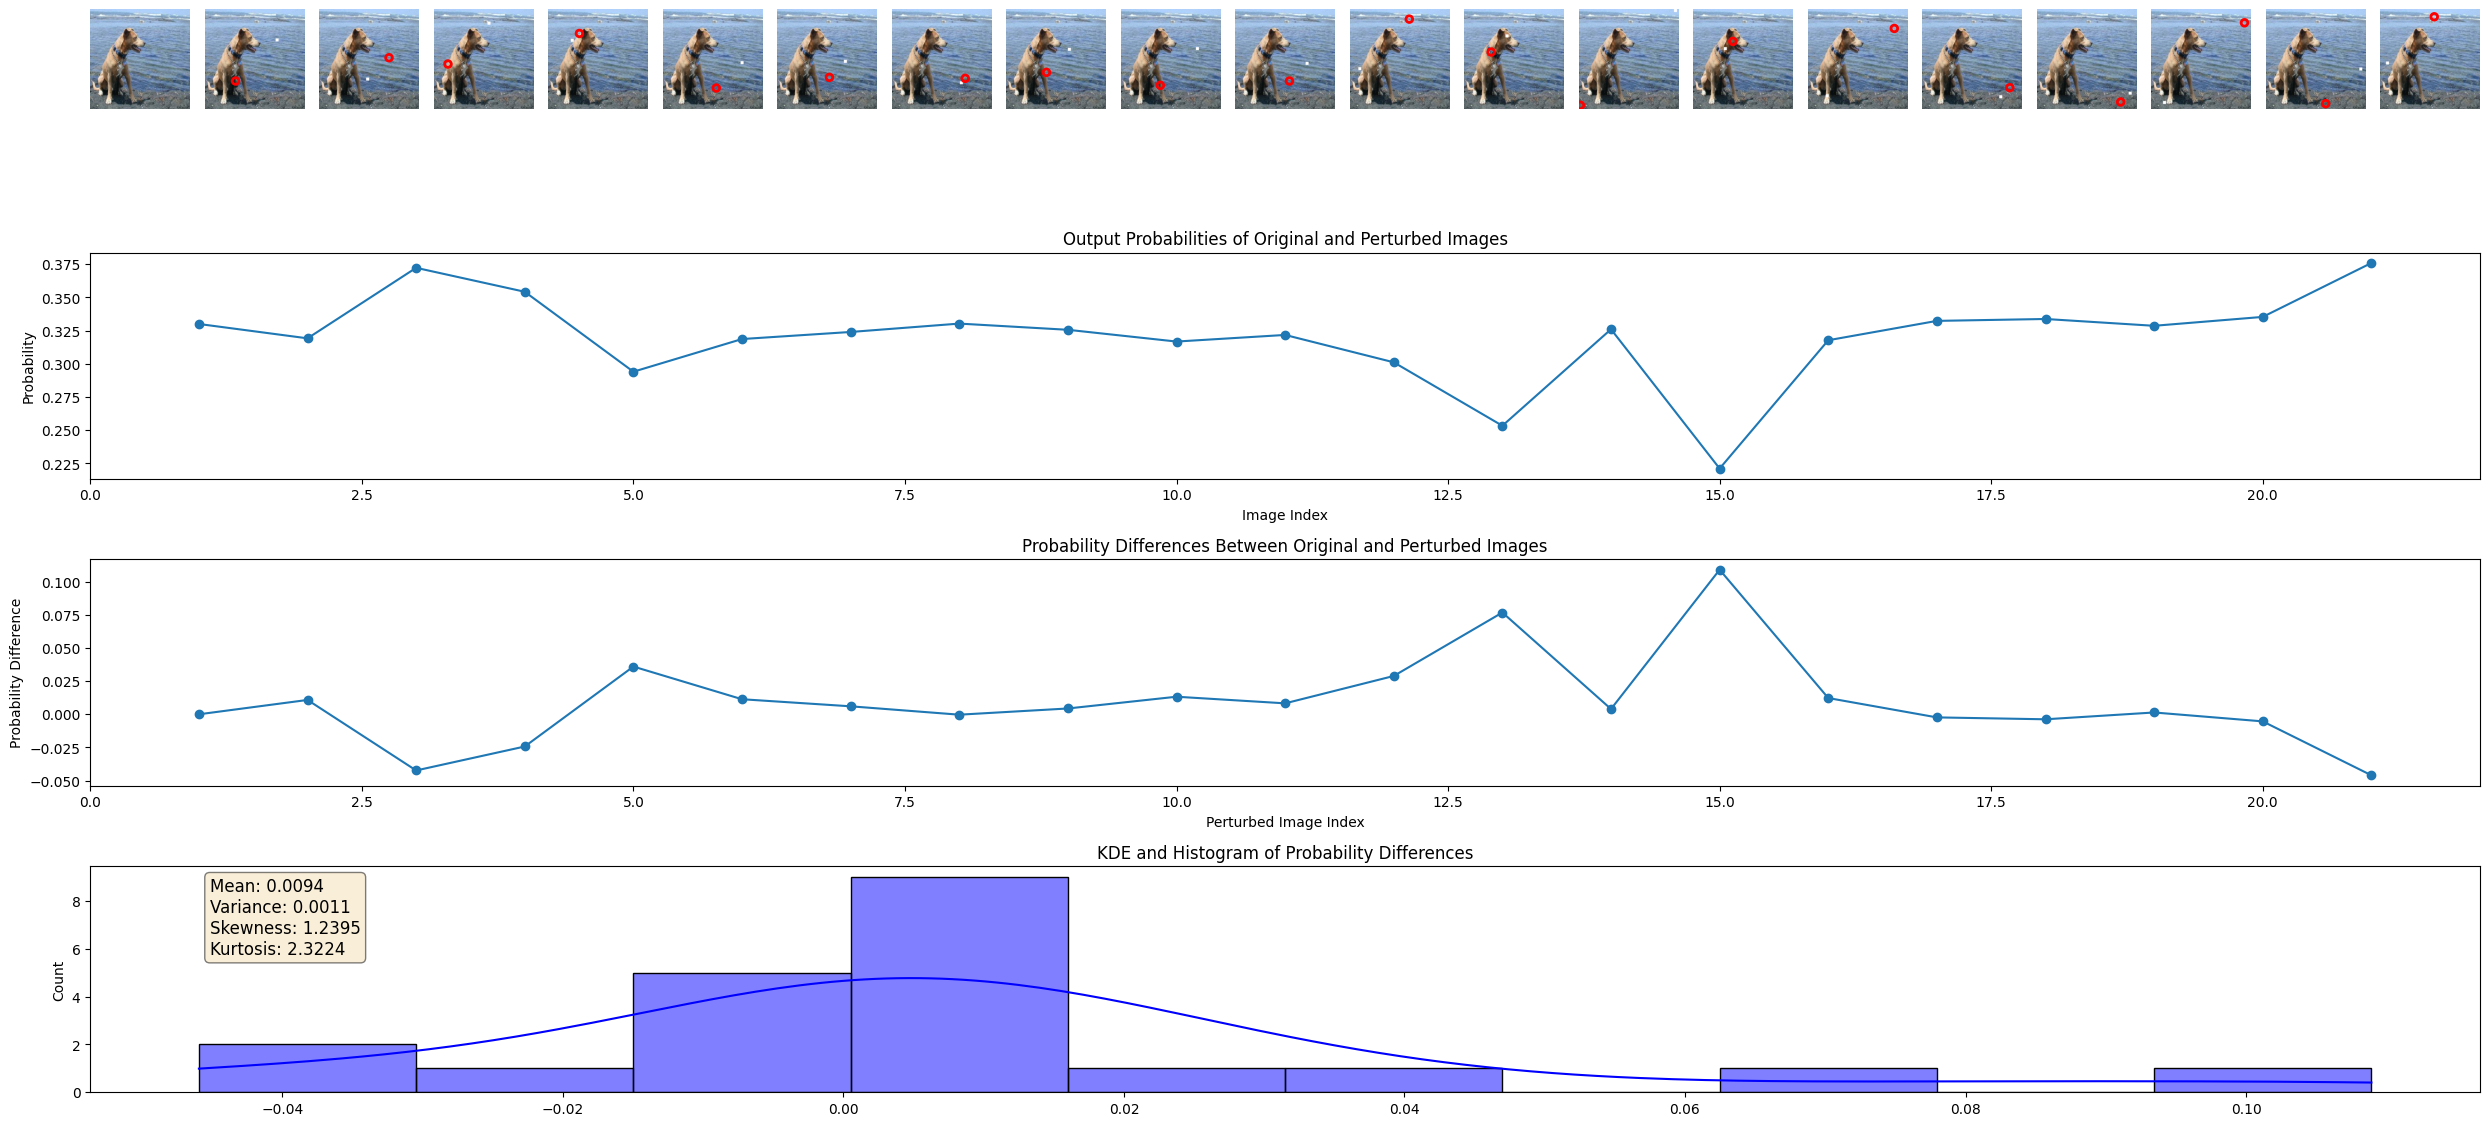

Images saved in /content/pert_images
CSV file saved at pert_images/perturbed_image_probabilities.csv


In [ ]:
import os
import pickle
import tensorflow as tf
import numpy as np
import copy
import csv
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle
from scipy.stats import skew, kurtosis

# Your existing configurations
num_pxls = 50
batch_size = 5
pert_types = ['U1']
model_names = ["xception"]
datasets = ["oxpets"]
log_id = 1
num_saved_images = 20  # Updated to 20 perturbed images (total 21 with original)
output_dir = "pert_images"
os.makedirs(output_dir, exist_ok=True)
csv_file = os.path.join(output_dir, "perturbed_image_probabilities.csv")

# Function to save image (unchanged)
def save_image(image_array, output_path):
    img = Image.fromarray(np.uint8(image_array))
    img.save(output_path)

# Function to plot images, probabilities, probability differences, and KDE/Histogram with statistics
def plot_images_and_statistics(original_image, perturbed_images, probabilities, prob_diffs, pert_pxl_list):
    fig = plt.figure(figsize=(25, 12))  # Adjusting the figure size for 21 images

    # 1. Plot the images in 21 subplots (1 original + 20 perturbed)
    for i in range(21):
        ax = fig.add_subplot(4, 21, i + 1)  # Create a 4-row grid with 21 columns
        if i == 0:
            ax.imshow(original_image.astype('uint8'))
        else:
            ax.imshow(perturbed_images[i-1].astype('uint8'))

        # Add a red circle centered at the specific perturbed pixel for this perturbed image
        if i > 0:
            center = pert_pxl_list[i-1]  # Use the i-th perturbed pixel for the i-th perturbed image
            circle = Circle((center[1], center[0]), 10, color='red', fill=False, linewidth=2)
            ax.add_patch(circle)
        ax.axis('off')

    # 2. Plot the actual probabilities in a line plot just below the images
    ax = fig.add_subplot(4, 1, 2)
    ax.plot(range(1, len(probabilities) + 1), probabilities, marker='o')
    ax.set_title("Output Probabilities of Original and Perturbed Images")
    ax.set_xlabel("Image Index")
    ax.set_ylabel("Probability")

    # 3. Plot the probability differences in a line plot below the probability plot
    ax = fig.add_subplot(4, 1, 3)
    ax.plot(range(1, len(prob_diffs) + 1), prob_diffs, marker='o')
    ax.set_title("Probability Differences Between Original and Perturbed Images")
    ax.set_xlabel("Perturbed Image Index")
    ax.set_ylabel("Probability Difference")

    # 4. Plot KDE and histogram of probability differences
    ax = fig.add_subplot(4, 1, 4)
    sns.histplot(prob_diffs, kde=True, ax=ax, color='blue', bins=10)

    # Compute statistics
    mean_diff = np.mean(prob_diffs)
    var_diff = np.var(prob_diffs)
    skew_diff = skew(prob_diffs)
    kurt_diff = kurtosis(prob_diffs)

    # Display statistics on the KDE plot
    textstr = '\n'.join((
        f'Mean: {mean_diff:.4f}',
        f'Variance: {var_diff:.4f}',
        f'Skewness: {skew_diff:.4f}',
        f'Kurtosis: {kurt_diff:.4f}'))

    # Placement of text box
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    ax.set_title("KDE and Histogram of Probability Differences")

    plt.tight_layout()
    plt.show()

# Open CSV file for writing
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["filename", "probability", "compared_to_prob0"])  # Header

    with tf.device('/device:GPU:0'):
        for dataset in datasets:
            for model_name in model_names:
                cam_dir, results_dir, img_dir = get_dataset_params(dataset, model_name)
                model, img_size, preprocess_input = get_model_params(model_name)
                cam_paths = os.listdir(cam_dir)
                cam_paths = cam_paths[9:10]  # Limit to specific range

                for idx, cam_path in enumerate(cam_paths):
                    with open(os.path.join(cam_dir, cam_path), 'rb') as file:
                        cam_dict = pickle.load(file)

                    img_path = os.path.join(img_dir, cam_path.replace('_cams.pkl', '.jpg'))
                    img = load_img(img_path, target_size=img_size, color_mode='rgb')
                    img_arr = img_to_array(img)

                    # Preprocess and predict on the original image
                    img_arr_b = tf.expand_dims(preprocess_input(copy.deepcopy(img_arr)), axis=0)
                    pred0 = model.predict(img_arr_b)
                    top_pred_class = pred0[0].argsort()[-1:][::-1]
                    prob0 = pred0[0][top_pred_class][0]

                    # Save the original image and log it in the CSV file
                    original_filename = f"{dataset}_{model_name}_original_{cam_path[:-4]}.png"
                    original_path = os.path.join(output_dir, original_filename)
                    save_image(img_arr, original_path)
                    writer.writerow([original_filename, prob0, "original"])

                    # Generate perturbed images
                    pert_pxl_list = select_n_random_pixels(img_size, num_pxls)

                    # Initialize lists to store probability differences, probabilities, and images
                    prob_diffs = [0]  # Start with 0 for the original image
                    probabilities = [prob0]  # Include the original probability
                    perturbed_images = []

                    # Loop through each perturbation type
                    for pert_type in pert_types:
                        perturbed_images_batch = generate_perturbed_images_patch(img=img_arr, coords=pert_pxl_list, patch_size=9, pert_type=pert_type)
                        pert_img_arrs = np.array(perturbed_images_batch)
                        pert_img_arrs = preprocess_input(pert_img_arrs)
                        preds = model.predict(pert_img_arrs, verbose=False)
                        probs_arr_batch = preds[:, top_pred_class]

                        # Collect probability differences, perturbed images, and probabilities
                        for pert_idx in range(len(perturbed_images_batch)):
                            prob_pert = probs_arr_batch[pert_idx][0]
                            prob_diff = prob0 - prob_pert  # No change here
                            prob_diffs.append(prob_diff)
                            probabilities.append(prob_pert)
                            perturbed_images.append(perturbed_images_batch[pert_idx])

                            # Break once we have exactly 20 perturbed images (for a total of 21 including the original)
                            if len(prob_diffs) == num_saved_images + 1:  # Adjust to account for initial 0
                                break
                        if len(prob_diffs) == num_saved_images + 1:  # Adjust to account for initial 0
                            break

                    # After collecting all probability differences, plot the images, probabilities, and statistics
                    if prob_diffs:
                        plot_images_and_statistics(img_arr, perturbed_images, probabilities, prob_diffs, pert_pxl_list)

print(f"Images saved in {os.getcwd()}/{output_dir}")
print(f"CSV file saved at {csv_file}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


<ipython-input-27-4b90c020e0ab>:106: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


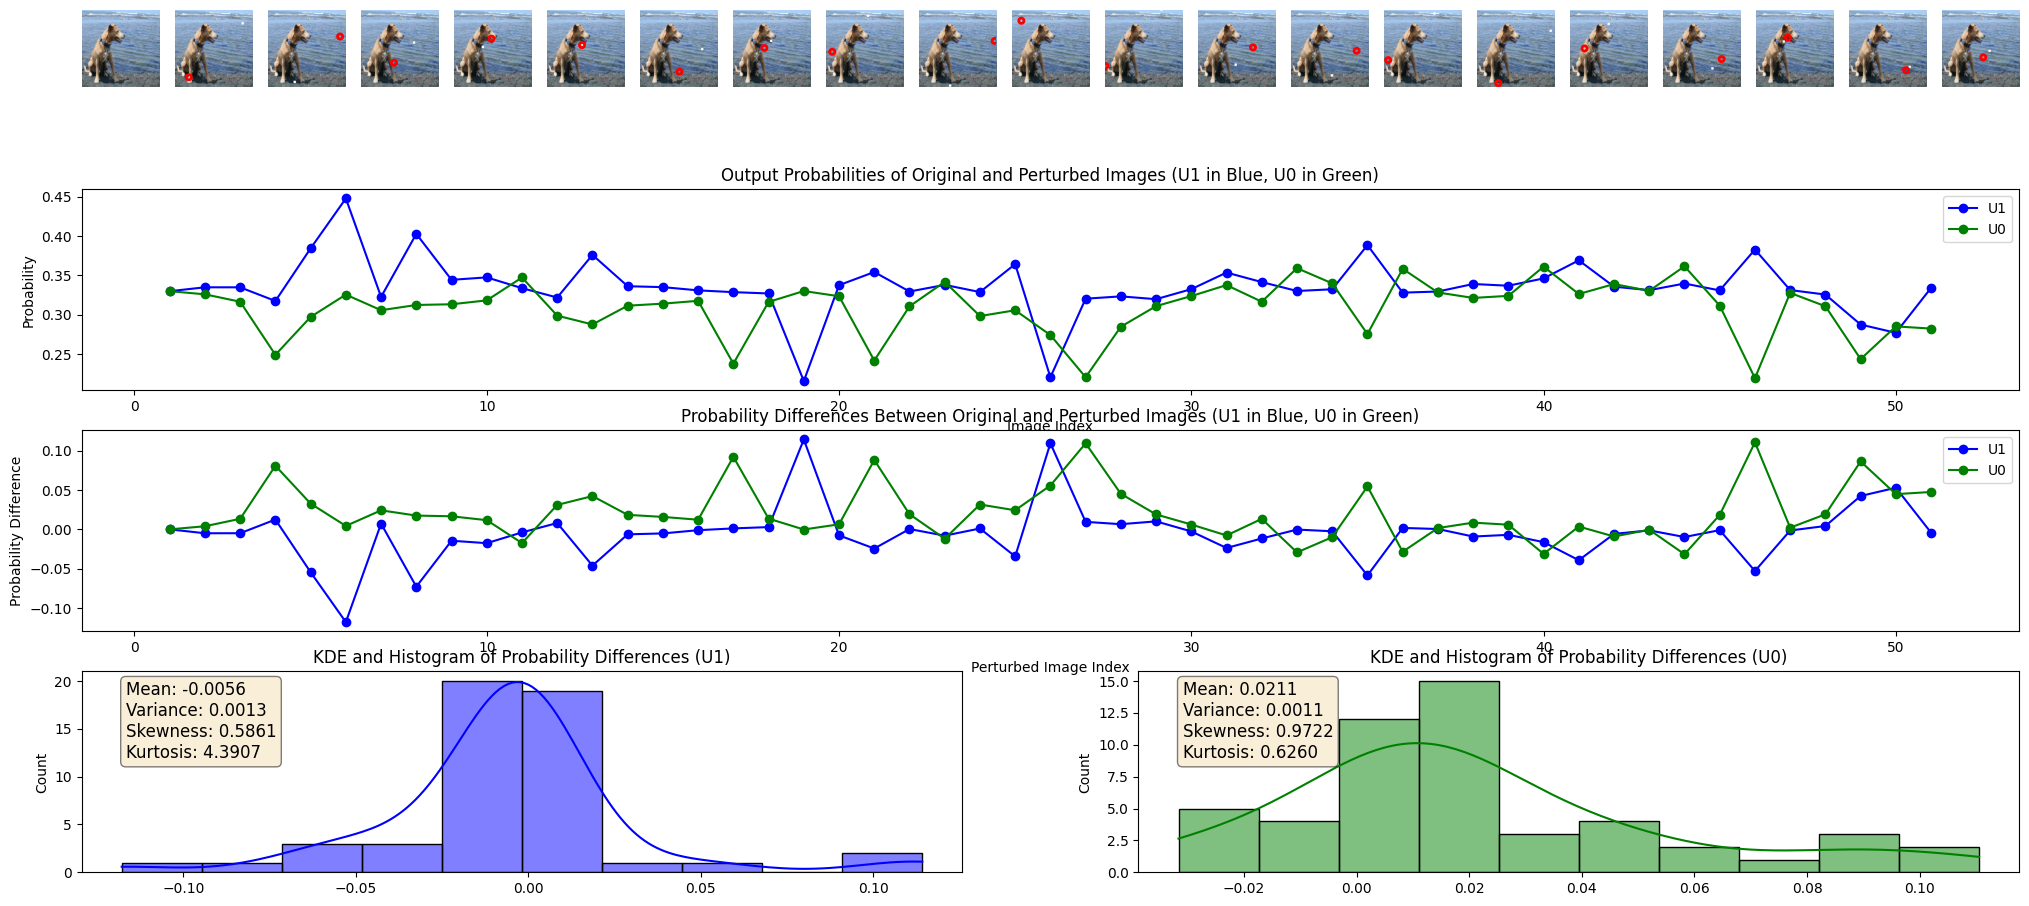

Images saved in /content/pert_images
CSV file saved at pert_images/perturbed_image_probabilities.csv


In [ ]:
###Additional IE features plot 1+20
import os
import pickle
import tensorflow as tf
import numpy as np
import copy
import csv
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle
from scipy.stats import skew, kurtosis

# Your existing configurations
num_pxls = 50
batch_size = 5
pert_types = ['U1', 'U0']  # Updated to include both perturbation types
model_names = ["xception"]
datasets = ["oxpets"]
log_id = 1
num_saved_images = 20  # Updated to 20 perturbed images (total 21 with original)
output_dir = "pert_images"
os.makedirs(output_dir, exist_ok=True)
csv_file = os.path.join(output_dir, "perturbed_image_probabilities.csv")

# Function to save image (unchanged)
def save_image(image_array, output_path):
    img = Image.fromarray(np.uint8(image_array))
    img.save(output_path)

# Function to plot images, probabilities, probability differences, and KDE/Histogram with statistics
def plot_images_and_statistics(original_image, perturbed_images, probabilities_U1, probabilities_U0, prob_diffs_U1, prob_diffs_U0, pert_pxl_list):
    fig = plt.figure(figsize=(25, 12))  # Adjusting the figure size for 21 images

    # 1. Plot the images in 21 subplots (1 original + 20 perturbed)
    for i in range(21):
        ax = fig.add_subplot(4, 21, i + 1)  # Create a 4-row grid with 21 columns
        if i == 0:
            ax.imshow(original_image.astype('uint8'))
        else:
            ax.imshow(perturbed_images[i-1].astype('uint8'))

        # Add a red circle centered at the specific perturbed pixel for this perturbed image
        if i > 0:
            center = pert_pxl_list[i-1]  # Use the i-th perturbed pixel for the i-th perturbed image
            circle = Circle((center[1], center[0]), 10, color='red', fill=False, linewidth=2)
            ax.add_patch(circle)
        ax.axis('off')

    # 2. Plot the actual probabilities for both U1 and U0 in a line plot
    ax = fig.add_subplot(4, 1, 2)
    ax.plot(range(1, len(probabilities_U1) + 1), probabilities_U1, marker='o', color='blue', label='U1')
    ax.plot(range(1, len(probabilities_U0) + 1), probabilities_U0, marker='o', color='green', label='U0')
    ax.set_title("Output Probabilities of Original and Perturbed Images (U1 in Blue, U0 in Green)")
    ax.set_xlabel("Image Index")
    ax.set_ylabel("Probability")
    ax.legend()

    # 3. Plot the probability differences for both U1 and U0 in a line plot
    ax = fig.add_subplot(4, 1, 3)
    ax.plot(range(1, len(prob_diffs_U1) + 1), prob_diffs_U1, marker='o', color='blue', label='U1')
    ax.plot(range(1, len(prob_diffs_U0) + 1), prob_diffs_U0, marker='o', color='green', label='U0')
    ax.set_title("Probability Differences Between Original and Perturbed Images (U1 in Blue, U0 in Green)")
    ax.set_xlabel("Perturbed Image Index")
    ax.set_ylabel("Probability Difference")
    ax.legend()

    # 4. Plot KDE and histogram of probability differences for U1 and U0 side by side
    ax1 = fig.add_subplot(4, 2, 7)  # Left plot for U1
    sns.histplot(prob_diffs_U1, kde=True, ax=ax1, color='blue', bins=10)
    ax1.set_title("KDE and Histogram of Probability Differences (U1)")

    # Compute statistics for U1
    mean_diff_U1 = np.mean(prob_diffs_U1)
    var_diff_U1 = np.var(prob_diffs_U1)
    skew_diff_U1 = skew(prob_diffs_U1)
    kurt_diff_U1 = kurtosis(prob_diffs_U1)

    # Display statistics for U1 on the KDE plot
    textstr_U1 = '\n'.join((
        f'Mean: {mean_diff_U1:.4f}',
        f'Variance: {var_diff_U1:.4f}',
        f'Skewness: {skew_diff_U1:.4f}',
        f'Kurtosis: {kurt_diff_U1:.4f}'))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax1.text(0.05, 0.95, textstr_U1, transform=ax1.transAxes, fontsize=12, verticalalignment='top', bbox=props)

    ax2 = fig.add_subplot(4, 2, 8)  # Right plot for U0
    sns.histplot(prob_diffs_U0, kde=True, ax=ax2, color='green', bins=10)
    ax2.set_title("KDE and Histogram of Probability Differences (U0)")

    # Compute statistics for U0
    mean_diff_U0 = np.mean(prob_diffs_U0)
    var_diff_U0 = np.var(prob_diffs_U0)
    skew_diff_U0 = skew(prob_diffs_U0)
    kurt_diff_U0 = kurtosis(prob_diffs_U0)

    # Display statistics for U0 on the KDE plot
    textstr_U0 = '\n'.join((
        f'Mean: {mean_diff_U0:.4f}',
        f'Variance: {var_diff_U0:.4f}',
        f'Skewness: {skew_diff_U0:.4f}',
        f'Kurtosis: {kurt_diff_U0:.4f}'))
    ax2.text(0.05, 0.95, textstr_U0, transform=ax2.transAxes, fontsize=12, verticalalignment='top', bbox=props)

    plt.tight_layout()
    plt.savefig("features_stats.png")
    plt.show()

# Open CSV file for writing
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["filename", "probability", "compared_to_prob0"])  # Header

    with tf.device('/device:GPU:0'):
        for dataset in datasets:
            for model_name in model_names:
                cam_dir, results_dir, img_dir = get_dataset_params(dataset, model_name)
                model, img_size, preprocess_input = get_model_params(model_name)
                cam_paths = os.listdir(cam_dir)
                cam_paths = cam_paths[9:10]  # Limit to specific range

                for idx, cam_path in enumerate(cam_paths):
                    with open(os.path.join(cam_dir, cam_path), 'rb') as file:
                        cam_dict = pickle.load(file)

                    img_path = os.path.join(img_dir, cam_path.replace('_cams.pkl', '.jpg'))
                    img = load_img(img_path, target_size=img_size, color_mode='rgb')
                    img_arr = img_to_array(img)

                    # Preprocess and predict on the original image
                    img_arr_b = tf.expand_dims(preprocess_input(copy.deepcopy(img_arr)), axis=0)
                    pred0 = model.predict(img_arr_b)
                    top_pred_class = pred0[0].argsort()[-1:][::-1]
                    prob0 = pred0[0][top_pred_class][0]

                    # Save the original image and log it in the CSV file
                    original_filename = f"{dataset}_{model_name}_original_{cam_path[:-4]}.png"
                    original_path = os.path.join(output_dir, original_filename)
                    save_image(img_arr, original_path)
                    writer.writerow([original_filename, prob0, "original"])

                    # Generate perturbed images
                    pert_pxl_list = select_n_random_pixels(img_size, num_pxls)

                    # Initialize lists to store probability differences, probabilities, and images for U1 and U0
                    prob_diffs_U1 = [0]  # Start with 0 for the original image
                    prob_diffs_U0 = [0]
                    probabilities_U1 = [prob0]  # Include the original probability
                    probabilities_U0 = [prob0]
                    perturbed_images = []

                    # Loop through each perturbation type
                    for pert_type in pert_types:
                        perturbed_images_batch = generate_perturbed_images_patch(img=img_arr, coords=pert_pxl_list, patch_size=9, pert_type=pert_type)
                        pert_img_arrs = np.array(perturbed_images_batch)
                        pert_img_arrs = preprocess_input(pert_img_arrs)
                        preds = model.predict(pert_img_arrs, verbose=False)
                        probs_arr_batch = preds[:, top_pred_class]

                        # Collect probability differences, perturbed images, and probabilities for each perturbation type
                        for pert_idx in range(len(perturbed_images_batch)):
                            prob_pert = probs_arr_batch[pert_idx][0]
                            prob_diff = prob0 - prob_pert  # No change here
                            if pert_type == 'U1':
                                prob_diffs_U1.append(prob_diff)
                                probabilities_U1.append(prob_pert)
                            elif pert_type == 'U0':
                                prob_diffs_U0.append(prob_diff)
                                probabilities_U0.append(prob_pert)
                            perturbed_images.append(perturbed_images_batch[pert_idx])

                            # Break once we have exactly 20 perturbed images (for a total of 21 including the original)
                            if len(prob_diffs_U1) == num_saved_images + 1 and len(prob_diffs_U0) == num_saved_images + 1:
                                break
                        if len(prob_diffs_U1) == num_saved_images + 1 and len(prob_diffs_U0) == num_saved_images + 1:
                            break

                    # After collecting all probability differences, plot the images, probabilities, and statistics
                    if prob_diffs_U1 and prob_diffs_U0:
                        plot_images_and_statistics(img_arr, perturbed_images, probabilities_U1, probabilities_U0, prob_diffs_U1, prob_diffs_U0, pert_pxl_list)

print(f"Images saved in {os.getcwd()}/{output_dir}")
print(f"CSV file saved at {csv_file}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


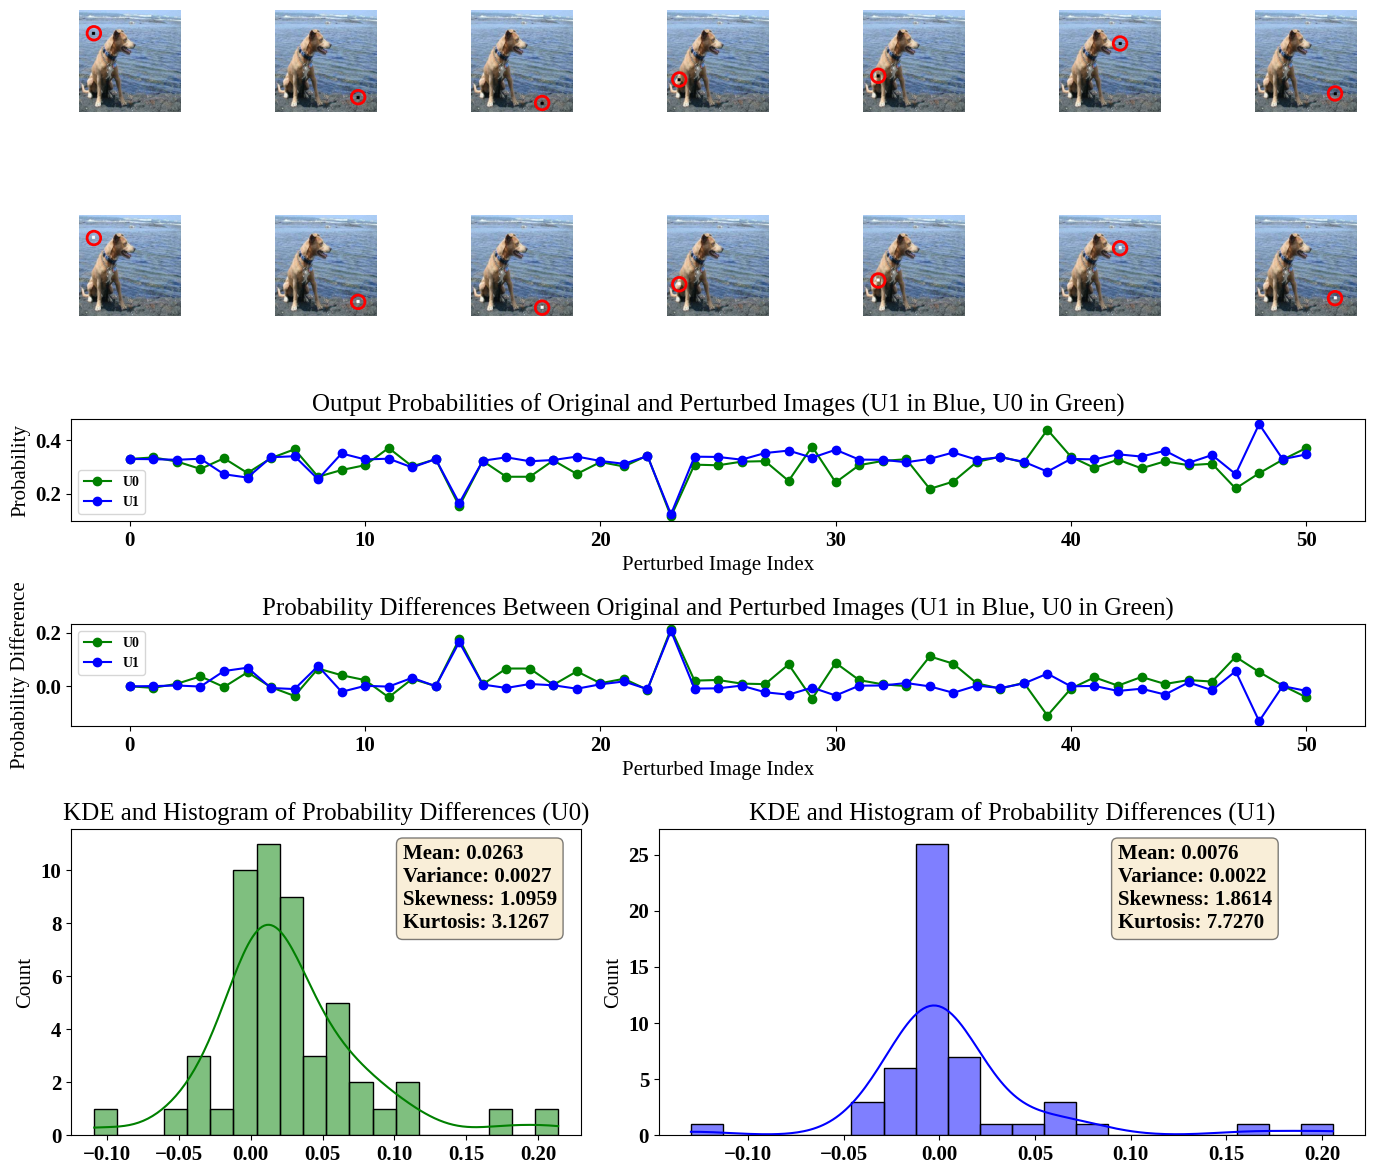

Images saved in /content/pert_images
CSV file saved at pert_images/perturbed_image_probabilities.csv


In [ ]:
import os
import pickle
import tensorflow as tf
import numpy as np
import copy
import csv
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle
from scipy.stats import skew, kurtosis
import matplotlib.gridspec as gridspec
import matplotlib as mpl

# Configure font properties
mpl.rcParams['font.family'] = 'Liberation Serif'
mpl.rcParams['font.size'] = 15
mpl.rcParams['font.weight'] = 'bold'


# Your existing configurations
num_pxls = 50
batch_size = 5
pert_types = ['U1', 'U0']  # Updated to include both perturbation types
model_names = ["xception"]
datasets = ["oxpets"]
log_id = 1
num_saved_images = 10  # Adjusted to 10 perturbed images (total 11 with original)
output_dir = "pert_images"
os.makedirs(output_dir, exist_ok=True)
csv_file = os.path.join(output_dir, "perturbed_image_probabilities.csv")

# Function to save image (unchanged)
def save_image(image_array, output_path):
    img = Image.fromarray(np.uint8(image_array))
    img.save(output_path)

# Function to plot images, probabilities, probability differences, and KDE/Histogram with statistics
# Function to plot images, probabilities, probability differences, and KDE/Histogram with statistics
def plot_images_and_statistics_old(original_image, perturbed_images_U0, perturbed_images_U1, probabilities_U1, probabilities_U0, prob_diffs_U1, prob_diffs_U0, pert_pxl_list, n_images):
    fig = plt.figure(figsize=(n_images * 2, 12))  # Adjust figure size dynamically based on the number of images

    # Create a GridSpec with equal height for rows
    gs = gridspec.GridSpec(6, n_images, height_ratios=[1, 1, 1, 1, 1, 1])  # Two rows for images

    # 1. First row: perturbed images for U0
    for i in range(0, n_images):
        ax = fig.add_subplot(gs[0, i])  # First row for U0 perturbed images
        ax.imshow(perturbed_images_U0[i - 1].astype('uint8'))

        # Add a red circle centered at the specific perturbed pixel for U0 perturbed image
        center = pert_pxl_list[i - 1]
        circle = Circle((center[0], center[1]), 20, color='red', fill=False, linewidth=2)  # Use fill=False for transparency
        ax.add_patch(circle)
        ax.axis('off')

    # 2. Second row: perturbed images for U1
    for i in range(0, n_images):
        ax = fig.add_subplot(gs[1, i])  # Second row for U1 perturbed images
        ax.imshow(perturbed_images_U1[i - 1].astype('uint8'))

        # Add a red circle centered at the specific perturbed pixel for U1 perturbed image
        center = pert_pxl_list[i - 1]
        circle = Circle((center[0], center[1]), 20, color='red', fill=False, linewidth=2)
        ax.add_patch(circle)
        ax.axis('off')

    # 3. Plot the actual probabilities for both U1 and U0 in a line plot (spanning all columns)
    ax = fig.add_subplot(gs[2, :])  # Third row, spans all columns
    ax.plot(range(0, len(probabilities_U0)), probabilities_U0, marker='o', color='green', label='U0')
    ax.plot(range(0, len(probabilities_U1)), probabilities_U1, marker='o', color='blue', label='U1')
    ax.set_title("Output Probabilities of Original and Perturbed Images (U0 in Green, U1 in Blue)")
    ax.set_xlabel("Perturbed Image Index")
    ax.set_ylabel("Probability")
    #ax.legend()

    # 4. Plot the probability differences for both U1 and U0 in a line plot (spanning all columns)
    ax = fig.add_subplot(gs[3, :])  # Fourth row, spans all columns
    ax.plot(range(0, len(prob_diffs_U0)), prob_diffs_U0, marker='o', color='green', label='U0')
    ax.plot(range(0, len(prob_diffs_U1)), prob_diffs_U1, marker='o', color='blue', label='U1')
    ax.set_title("Probability Differences Between Original and Perturbed Images (U0 in Green, U1 in Blue)")
    ax.set_xlabel("Perturbed Image Index")
    ax.set_ylabel("Probability Difference")
    #ax.legend()

    # 5. Plot KDE and histogram of probability differences for U0 (left) and U1 (right) side by side
    ax1 = fig.add_subplot(gs[4:6, :n_images // 2])  # Left plot for U0
    sns.histplot(prob_diffs_U0, kde=True, ax=ax1, color='green', bins=20)
    ax1.set_title("KDE and Histogram of Probability Differences (U0)")

    # Compute statistics for U0
    mean_diff_U0 = np.mean(prob_diffs_U0)
    var_diff_U0 = np.var(prob_diffs_U0)
    skew_diff_U0 = skew(prob_diffs_U0)
    kurt_diff_U0 = kurtosis(prob_diffs_U0)

    # Display statistics for U0 on the KDE plot in a non-overlapping location
    textstr_U0 = '\n'.join((
        f'Mean: {mean_diff_U0:.4f}',
        f'Variance: {var_diff_U0:.4f}',
        f'Skewness: {skew_diff_U0:.4f}',
        f'Kurtosis: {kurt_diff_U0:.4f}'))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax1.text(0.65, 0.95, textstr_U0, transform=ax1.transAxes, fontsize=15, verticalalignment='top', bbox=props)

    ax2 = fig.add_subplot(gs[4:6, n_images // 2:])  # Right plot for U1
    sns.histplot(prob_diffs_U1, kde=True, ax=ax2, color='blue', bins=20)
    ax2.set_title("KDE and Histogram of Probability Differences (U1)")

    # Compute statistics for U1
    mean_diff_U1 = np.mean(prob_diffs_U1)
    var_diff_U1 = np.var(prob_diffs_U1)
    skew_diff_U1 = skew(prob_diffs_U1)
    kurt_diff_U1 = kurtosis(prob_diffs_U1)

    # Display statistics for U1 on the KDE plot in a non-overlapping location
    textstr_U1 = '\n'.join((
        f'Mean: {mean_diff_U1:.4f}',
        f'Variance: {var_diff_U1:.4f}',
        f'Skewness: {skew_diff_U1:.4f}',
        f'Kurtosis: {kurt_diff_U1:.4f}'))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax2.text(0.65, 0.95, textstr_U1, transform=ax2.transAxes, fontsize=15, verticalalignment='top', bbox=props)

    plt.tight_layout()
    plt.savefig("features_stats.png")
    plt.show()


# Function to plot images, probabilities, probability differences, and KDE/Histogram with statistics
def plot_images_and_statistics(original_image, perturbed_images_U0, perturbed_images_U1, probabilities_U1, probabilities_U0, prob_diffs_U1, prob_diffs_U0, pert_pxl_list, n_images):
    fig = plt.figure(figsize=(n_images * 2, 12))  # Adjust figure size dynamically based on the number of images

    # Adjust height ratios to reduce space between rows
    gs = gridspec.GridSpec(6, n_images, height_ratios=[1, 1, 1, 1, 1, 1])  # Reduced space for image rows

    # 1. First row: perturbed images for U0
    for i in range(0, n_images):
        ax = fig.add_subplot(gs[0, i])  # First row for U0 perturbed images
        ax.imshow(perturbed_images_U0[i - 1].astype('uint8'))

        # Add a red circle centered at the specific perturbed pixel for U0 perturbed image
        center = pert_pxl_list[i - 1]
        circle = Circle((center[0], center[1]), 20, color='red', fill=False, linewidth=2)  # Use fill=False for transparency
        ax.add_patch(circle)
        ax.axis('off')

    # 2. Second row: perturbed images for U1
    for i in range(0, n_images):
        ax = fig.add_subplot(gs[1, i])  # Second row for U1 perturbed images
        ax.imshow(perturbed_images_U1[i - 1].astype('uint8'))

        # Add a red circle centered at the specific perturbed pixel for U1 perturbed image
        center = pert_pxl_list[i - 1]
        circle = Circle((center[0], center[1]), 20, color='red', fill=False, linewidth=2)
        ax.add_patch(circle)
        ax.axis('off')

    # 3. Plot the actual probabilities for both U1 and U0 in a line plot (spanning all columns)
    ax = fig.add_subplot(gs[2, :])  # Third row, spans all columns
    ax.plot(range(0, len(probabilities_U0)), probabilities_U0, marker='o', color='green', label='U0')
    ax.plot(range(0, len(probabilities_U1)), probabilities_U1, marker='o', color='blue', label='U1')
    ax.set_title("Output Probabilities of Original and Perturbed Images (U1 in Blue, U0 in Green)")
    ax.set_xlabel("Perturbed Image Index")
    ax.set_ylabel("Probability")
    ax.legend(loc='lower left', bbox_to_anchor=(0, 0), fontsize=10)  # Move legend to the top-right corner outside the plot

    # 4. Plot the probability differences for both U1 and U0 in a line plot (spanning all columns)
    ax = fig.add_subplot(gs[3, :])  # Fourth row, spans all columns
    ax.plot(range(0, len(prob_diffs_U0)), prob_diffs_U0, marker='o', color='green', label='U0')
    ax.plot(range(0, len(prob_diffs_U1)), prob_diffs_U1, marker='o', color='blue', label='U1')
    ax.set_title("Probability Differences Between Original and Perturbed Images (U1 in Blue, U0 in Green)")
    ax.set_xlabel("Perturbed Image Index")
    ax.set_ylabel("Probability Difference")
    ax.legend(loc='upper left', bbox_to_anchor=(0, 1), fontsize=10)  # Move legend to the top-right corner outside the plot

    # 5. Plot KDE and histogram of probability differences for U0 (left) and U1 (right) side by side
    ax1 = fig.add_subplot(gs[4:6, :n_images // 2])  # Left plot for U0
    sns.histplot(prob_diffs_U0, kde=True, ax=ax1, color='green', bins=20)
    ax1.set_title("KDE and Histogram of Probability Differences (U0)")

    # Compute statistics for U0
    mean_diff_U0 = np.mean(prob_diffs_U0)
    var_diff_U0 = np.var(prob_diffs_U0)
    skew_diff_U0 = skew(prob_diffs_U0)
    kurt_diff_U0 = kurtosis(prob_diffs_U0)

    # Display statistics for U0 on the KDE plot in a non-overlapping location
    textstr_U0 = '\n'.join((f'Mean: {mean_diff_U0:.4f}',
                            f'Variance: {var_diff_U0:.4f}',
                            f'Skewness: {skew_diff_U0:.4f}',
                            f'Kurtosis: {kurt_diff_U0:.4f}'))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax1.text(0.65, 0.95, textstr_U0, transform=ax1.transAxes, fontsize=15, verticalalignment='top', bbox=props)

    ax2 = fig.add_subplot(gs[4:6, n_images // 2:])  # Right plot for U1
    sns.histplot(prob_diffs_U1, kde=True, ax=ax2, color='blue', bins=20)
    ax2.set_title("KDE and Histogram of Probability Differences (U1)")

    # Compute statistics for U1
    mean_diff_U1 = np.mean(prob_diffs_U1)
    var_diff_U1 = np.var(prob_diffs_U1)
    skew_diff_U1 = skew(prob_diffs_U1)
    kurt_diff_U1 = kurtosis(prob_diffs_U1)

    # Display statistics for U1 on the KDE plot in a non-overlapping location
    textstr_U1 = '\n'.join((f'Mean: {mean_diff_U1:.4f}',
                            f'Variance: {var_diff_U1:.4f}',
                            f'Skewness: {skew_diff_U1:.4f}',
                            f'Kurtosis: {kurt_diff_U1:.4f}'))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax2.text(0.65, 0.95, textstr_U1, transform=ax2.transAxes, fontsize=15, verticalalignment='top', bbox=props)

    # Adjust space between rows
    plt.subplots_adjust(hspace=0.01)  # Reduce the vertical space between rows

    plt.tight_layout()
    plt.savefig("features_stats.png", dpi=600)
    plt.show()



# Open CSV file for writing
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["filename", "probability", "compared_to_prob0"])  # Header

    with tf.device('/device:GPU:0'):
        for dataset in datasets:
            for model_name in model_names:
                cam_dir, results_dir, img_dir = get_dataset_params(dataset, model_name)
                model, img_size, preprocess_input = get_model_params(model_name)
                cam_paths = os.listdir(cam_dir)
                cam_paths = cam_paths[9:10]  # Limit to specific range

                for idx, cam_path in enumerate(cam_paths):
                    with open(os.path.join(cam_dir, cam_path), 'rb') as file:
                        cam_dict = pickle.load(file)

                    img_path = os.path.join(img_dir, cam_path.replace('_cams.pkl', '.jpg'))
                    img = load_img(img_path, target_size=img_size, color_mode='rgb')
                    img_arr = img_to_array(img)

                    # Preprocess and predict on the original image
                    img_arr_b = tf.expand_dims(preprocess_input(copy.deepcopy(img_arr)), axis=0)
                    pred0 = model.predict(img_arr_b)
                    top_pred_class = pred0[0].argsort()[-1:][::-1]
                    prob0 = pred0[0][top_pred_class][0]

                    # Save the original image and log it in the CSV file
                    original_filename = f"{dataset}_{model_name}_original_{cam_path[:-4]}.png"
                    original_path = os.path.join(output_dir, original_filename)
                    save_image(img_arr, original_path)
                    writer.writerow([original_filename, prob0, "original"])

                    # Generate perturbed images for U0 and U1
                    pert_pxl_list = select_n_random_pixels(img_size, num_pxls)

                    perturbed_images_U0 = generate_perturbed_images_patch(img=img_arr, coords=pert_pxl_list, patch_size=9, pert_type='U0')
                    perturbed_images_U1 = generate_perturbed_images_patch(img=img_arr, coords=pert_pxl_list, patch_size=9, pert_type='U1')

                    # Initialize lists to store probability differences, probabilities for U1 and U0
                    prob_diffs_U1 = [0]
                    prob_diffs_U0 = [0]
                    probabilities_U1 = [prob0]  # Include the original probability
                    probabilities_U0 = [prob0]

                    # Predict for U0 perturbed images
                    pert_img_arrs_U0 = preprocess_input(np.array(perturbed_images_U0))
                    preds_U0 = model.predict(pert_img_arrs_U0, verbose=False)
                    probs_arr_batch_U0 = preds_U0[:, top_pred_class]

                    # Predict for U1 perturbed images
                    pert_img_arrs_U1 = preprocess_input(np.array(perturbed_images_U1))
                    preds_U1 = model.predict(pert_img_arrs_U1, verbose=False)
                    probs_arr_batch_U1 = preds_U1[:, top_pred_class]

                    # Collect probability differences and probabilities for U0 and U1
                    for pert_idx in range(len(perturbed_images_U0)):
                        prob_pert_U0 = probs_arr_batch_U0[pert_idx][0]
                        prob_diff_U0 = prob0 - prob_pert_U0
                        prob_diffs_U0.append(prob_diff_U0)
                        probabilities_U0.append(prob_pert_U0)

                    for pert_idx in range(len(perturbed_images_U1)):
                        prob_pert_U1 = probs_arr_batch_U1[pert_idx][0]
                        prob_diff_U1 = prob0 - prob_pert_U1
                        prob_diffs_U1.append(prob_diff_U1)
                        probabilities_U1.append(prob_pert_U1)

                    # After collecting all probability differences, plot the images, probabilities, and statistics
                    if prob_diffs_U1 and prob_diffs_U0:
                        plot_images_and_statistics(img_arr, perturbed_images_U0, perturbed_images_U1, probabilities_U1, probabilities_U0, prob_diffs_U1, prob_diffs_U0, pert_pxl_list, n_images=7)

print(f"Images saved in {os.getcwd()}/{output_dir}")
print(f"CSV file saved at {csv_file}")

In [ ]:
len(prob_diffs_U1)

51